In [1]:
import numpy as np
import pandas as pd
import patsy
import itertools

from sklearn.linear_model import (Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, 
                     LassoCV, ElasticNetCV,  SGDRegressor, SGDClassifier)

from sklearn.grid_search import GridSearchCV, RandomizedSearchCV

from sklearn.cross_validation import cross_val_score
from sklearn.metrics import mean_squared_error

from sklearn import grid_search, datasets

import datetime
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_model import ARMA
from sklearn.metrics import r2_score

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<center>
<h1> <b> Problem statement </b> <h1>
<h2> <center>  What relationship are there between PGE electrical usage  and solar power accumulation 
in CA in 2012 - 2016?  </h2>
</center>

Context: In CA, California Public Utilities Commision (CPUC) regulates California’s three large investor owned electric utilities – Pacific Gas and Electric (PG&E), Southern California Edison (SCE), and San Diego Gas and Electric (SDG&E). This study focuses on just PGE, so it is therefore incomplete.
<br>
As we see some of the numbers below, PG&E only covers a portions of the state's area.
<br>
This means that only 818/2667 = 0.3067 ZIP codes have solar power in CA! The PGE number depends on the sampling rate. Since ZIP codes are propotional to population, PG&E covers only about 30% of CA.
<br>
I have not found yet another study of PG&E electical usage vs solar power generation, so I cannot compare these results with any prior work.


<center>
<h2> 1. Load in Q1 - Q2 for 2012 -  2016 electric data from PG&E  </h2>
</center>

In [2]:
#2016, Q1-Q2
pge_q1 = pd.read_csv("PGE_2016_Q1_ElectricUsageByZip.csv")
pge_q2 = pd.read_csv("PGE_2016_Q2_ElectricUsageByZip.csv")

#2015, Q1-Q2
pge_q3 = pd.read_csv("PGE_2015_Q1_ElectricUsageByZip.csv")
pge_q4 = pd.read_csv("PGE_2015_Q2_ElectricUsageByZip.csv")

# 2014
pge_q5 = pd.read_csv("PGE_2014_Q1_ElectricUsageByZip.csv")
pge_q6 = pd.read_csv("PGE_2014_Q2_ElectricUsageByZip.csv")

#2013
pge_q7 = pd.read_csv("PGE_2013_Q1_ElectricUsageByZip.csv")
pge_q8 = pd.read_csv("PGE_2013_Q2_ElectricUsageByZip.csv")

#2012
pge_q9 = pd.read_csv("PGE_2012_Q1_ElectricUsageByZip.csv")
pge_q10 = pd.read_csv("PGE_2012_Q2_ElectricUsageByZip.csv")

In [3]:
pge_q1.head()

,ZipCode,Month,Year,CustomerClass,Combined,TotalCustomers,TotalkWh,AveragekWh
0,93101,1,2016,Elec- Commercial,Y,0,0,NaN
1,93101,1,2016,Elec- Residential,Y,0,0,NaN
2,93105,1,2016,Elec- Commercial,Y,0,0,NaN
3,93105,1,2016,Elec- Residential,Y,0,0,NaN
4,93110,1,2016,Elec- Commercial,Y,0,0,NaN


In [4]:
pge_q2.tail()

,ZipCode,Month,Year,CustomerClass,Combined,TotalCustomers,TotalkWh,AveragekWh
7733,96130,6,2016,Elec- Commercial,Y,0,0,NaN
7734,96137,6,2016,Elec- Commercial,Y,0,0,NaN
7735,96137,6,2016,Elec- Residential,N,"2,666","942,959",354
7736,96161,6,2016,Elec- Commercial,Y,0,0,NaN
7737,96161,6,2016,Elec- Residential,Y,0,0,NaN


<h2> 2. Let's do some data cleanup & EDA </h2>

In [5]:
pge_q1_df = pd.DataFrame(pge_q1)
pge_q2_df = pd.DataFrame(pge_q2)
pge_q3_df = pd.DataFrame(pge_q3)
pge_q4_df = pd.DataFrame(pge_q4)
pge_q5_df = pd.DataFrame(pge_q5)
pge_q6_df = pd.DataFrame(pge_q6)
pge_q7_df = pd.DataFrame(pge_q7)
pge_q8_df = pd.DataFrame(pge_q8)
pge_q9_df = pd.DataFrame(pge_q9)
pge_q10_df = pd.DataFrame(pge_q10)

In [6]:
pge_q = pd.concat([pge_q1_df, pge_q2_df, pge_q3_df, pge_q4_df, pge_q5_df, pge_q6_df, 
                  pge_q8_df, pge_q9_df, pge_q10_df])

In [7]:
pge_q.shape

(68587, 8)

<h3> For analysis on the Mac Book Pro I wil use only a fraction of the full data. I will use the full data set
when I run this on an AWS host.  </h3>

In [8]:
pge_q = pge_q.sample(frac=0.05)

In [9]:
pge_q.shape

(3429, 8)

In [10]:
pge_q.columns = [x.replace(',','') for x in pge_q.columns]

In [11]:
pge_q['AveragekWh']  = [ np.nan_to_num(x) for x in  pge_q['AveragekWh']]

In [12]:
pge_q.TotalkWh = [(x.replace(',','')) for x in pge_q.TotalkWh]

In [13]:
pge_q.Combined = pge_q.Combined.map(lambda x: 1 if x == 'N' else 0)

In [14]:
pge_q.CustomerClass.unique()

array(['Elec- Agricultural', 'Elec- Commercial', 'Elec- Residential',
       'Elec- Industrial'], dtype=object)

In [15]:
def cust_clean(x):
    
    if x == 'Elec- Commercial':
        x  = 1
    elif x == 'Elec- Residential':
         x = 2
    elif x == 'Elec- Agricultural':
         x = 3
    elif x == 'Elec- Industrial':
         x = 4

    return x

In [16]:
pge_q.CustomerClass = pge_q.CustomerClass.apply(cust_clean)

In [17]:
pge_q.CustomerClass.unique()

array([3, 1, 2, 4])

In [18]:
pge_q.AveragekWh.head()

997       0
5634      0
6404    751
1133      0
6582    556
Name: AveragekWh, dtype: object

In [19]:
pge_q.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3429 entries, 997 to 4749
Data columns (total 8 columns):
ZipCode           3429 non-null int64
Month             3429 non-null int64
Year              3429 non-null int64
CustomerClass     3429 non-null int64
Combined          3429 non-null int64
TotalCustomers    3429 non-null object
TotalkWh          3429 non-null object
AveragekWh        3429 non-null object
dtypes: int64(5), object(3)
memory usage: 241.1+ KB


In [20]:
len(pge_q['ZipCode'].unique())

852

In [21]:
len(pge_q['TotalCustomers'].unique())

1300

In [22]:
pge_q_num_cols = pge_q.columns
print pge_q_num_cols
pge_q_num = pge_q[pge_q_num_cols]

Index([u'ZipCode', u'Month', u'Year', u'CustomerClass', u'Combined',
       u'TotalCustomers', u'TotalkWh', u'AveragekWh'],
      dtype='object')


In [23]:
pge_q_num.TotalCustomers = [x.replace(',','') for x in pge_q_num.TotalCustomers]

In [24]:
pge_q_num['AveragekWh_22'] = pge_q_num['AveragekWh'].astype(str)

In [25]:
pge_q_num.AveragekWh_22 = [x.replace(',','') for x in pge_q_num.AveragekWh_22]

In [26]:
pge_q_num = pge_q_num[pge_q_num.Combined != 0]

In [27]:
pge_q_num.TotalCustomers = pge_q_num.TotalCustomers.astype(float)
pge_q_num.TotalkWh = pge_q_num.TotalkWh.astype(float)
pge_q_num.AveragekWh_22 = pge_q_num.AveragekWh_22.astype(float)
pge_q_num.AveragekWh = pge_q_num.AveragekWh_22

In [28]:
del pge_q_num['AveragekWh_22']

In [29]:
pge_q_num.head(3)

,ZipCode,Month,Year,CustomerClass,Combined,TotalCustomers,TotalkWh,AveragekWh
6404,95252,3,2012,2,1,4367.0,3279187.0,751.0
6582,95215,3,2015,2,1,6439.0,3579054.0,556.0
1824,95460,1,2015,2,1,1050.0,740381.0,705.0


In [30]:
pge_q_num.shape

(1253, 8)

<h2> 2.1 Data connecting ZIP codes to climage zones. </h2>

We will get data which connects ZIP codes to climate zones. PG&E uses ZIP codes to
organize its data; solar power data uses climate zones. To connects these 2 sets of data, will use this data set here.

In [31]:
zip_to_zones_data = pd.read_csv('BuildingClimateZonesByZIPCode.csv')

In [32]:
zip_to_zones_df = pd.DataFrame(zip_to_zones_data)

In [33]:
zip_to_zones_df['ZIP Code'].max()

96162.0

In [34]:
zip_to_zones_df.shape

(1724, 5)

In [35]:
zip_to_zones_df.tail(3)

,ZIP Code,Building Climate Zone,Unnamed: 2,Unnamed: 3,Unnamed: 4
1721,96161.0,16.0,NaN,NaN,NaN
1722,96162.0,16.0,NaN,NaN,NaN
1723,NaN,NaN,NaN,NaN,NaN


In [36]:
zip_to_zones_df.columns = [x.replace(' ','_') for x in zip_to_zones_df.columns]

In [37]:
zip_to_zones_df.ZIP_Code.head(3)

0    12.0
1    16.0
2    17.0
Name: ZIP_Code, dtype: float64

Dictonary connecting ZIP codes to climate zones.

In [38]:
zip_to_zones_dict = {}
for zip in range(0,zip_to_zones_df.shape[0]):
    zip_val = zip_to_zones_df.iloc[zip, 0]
    zone_val = zip_to_zones_df.iloc[zip, 1]
    zip_to_zones_dict[zip_val]  = zone_val

    
zip_to_zones_dict[float(93206)]

13.0

In [39]:
pge_q_num['zone'] = pge_q_num['ZipCode'].map(zip_to_zones_dict)

In [40]:
pge_q_num.dropna(inplace=True)

In [41]:
pge_q_num.head(2)

,ZipCode,Month,Year,CustomerClass,Combined,TotalCustomers,TotalkWh,AveragekWh,zone
6404,95252,3,2012,2,1,4367.0,3279187.0,751.0,12.0
6582,95215,3,2015,2,1,6439.0,3579054.0,556.0,12.0


In [42]:
pge_q_num.zone.unique()

array([ 12.,   1.,   5.,   4.,   2.,   3.,  13.,  16.,  11.])

<h2> 2.2 Temperatures in climate zones  in CA. </h2>

In [43]:
ca_2015_zone_temp = pd.read_csv('ca_2015_zone_temp.csv')

In [44]:
ca_2015_zone_temp_df = pd.DataFrame(ca_2015_zone_temp)

In [45]:
ca_2015_zone_temp_df_num_cols = [c for c in ca_2015_zone_temp_df.columns if c != 'Year']

In [46]:
ca_2015_zone_temp_df_num = ca_2015_zone_temp_df[ca_2015_zone_temp_df_num_cols]

In [47]:
ca_2015_zone_temp_df_num.head(3)

,Zone,Jan_Ave_Temp,Feb_Ave_Temp,Mar_Ave_Temp,Apr_Ave_Temp,May_Ave_Temp,Jun_Ave_Temp,Jul_Ave_Temp,Aug_Ave_Temp,Sep_Ave_Temp,Oct_Ave_Temp,Nov_Ave_Temp,Dec_Ave_Temp
0,1,48,49,49,50,52,65,66,67,67,55.1,52,49.7
1,2,48,51,52,55,60,65,68,68,68,65.1,55,49.7
2,3,48,52,54,55,59,62,63,64,65,60.1,55,49.9


<h2> 2.3 Let's get now some solar install data. </h2>

In [264]:
# Older 2015 data
ca_solar1 = pd.read_csv('ca-solar-stats-figure-data-2016-09-27.csv')

# 2015 data
ca_solar2 = pd.read_csv('ca-solar-stats-figure-data-2016-09-08.csv')

# 2012-2016 data
ca_solar3 = pd.read_csv('ca-solar-stats-figure-data-2016-09-29.csv')

In [265]:
ca_solar_df1 = pd.DataFrame(ca_solar1)
ca_solar_df2 = pd.DataFrame(ca_solar2)
ca_solar_df3 = pd.DataFrame(ca_solar3)

In [266]:
ca_solar_df = pd.concat([ca_solar_df1, ca_solar_df2, ca_solar_df3])
#ca_solar_df = ca_solar_df3

In [267]:
ca_solar_df.shape

(90918, 123)

For analysis on the Mac Book Pro I wil use only a fraction of the full data. I will use the full data set
when I run this on an AWS host. 

In [268]:
ca_solar_df = ca_solar_df.sample(frac=0.05)

In [269]:
ca_solar_df.shape

(4546, 123)

In [270]:
ca_solar_df.head(3)

,Application Number,Program Administrator,Program,Incentive Design,Incentive Type,Incentive Step,Incentive Amount,Total Cost,Nameplate Rating,CEC PTC Rating,...,CEC PTC Rating Single-Axis Tracking,CEC PTC Rating Dual-Axis Tracking,CSI Rating Fixed,CSI Rating Single-Axis Tracking,CSI Rating Dual-Axis Tracking,MASH Track 1A Incentive Amount,MASH Track 1B Incentive Amount,MASH Track 2 Incentive Amount,MASH Track 1A % Capacity,MASH Track 1B % Capacity
42006,PGE-CSI-42400,PG&E,Small Commercial (< 10 kW) and All Residential,$0.35 per Watt EPBB,EPBB,Step 8a,2378.0,44472.0,8.16,7.014,...,0.0,0.0,6.795,0.0,0.0,NaN,NaN,NaN,NaN,NaN
118,PGE-CSI-62415,PG&E,Small Commercial (< 10 kW) and All Residential,$0.20 per Watt EPBB,EPBB,Step 10,475.0,11053.0,3.00,2.608,...,0.0,0.0,2.376,0.0,0.0,NaN,NaN,NaN,NaN,NaN
25094,PGE-CSI-66103,PG&E,Small Commercial (< 10 kW) and All Residential,$0.20 per Watt EPBB,EPBB,Step 10,1845.0,48982.9,10.92,9.491,...,0.0,0.0,9.226,0.0,0.0,NaN,NaN,NaN,NaN,NaN


In [271]:
ca_solar_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4546 entries, 42006 to 57805
Columns: 123 entries, Application Number to MASH Track 1B % Capacity
dtypes: float64(56), int64(1), object(66)
memory usage: 4.3+ MB


In [272]:
quantity_cols  = []
for col in ca_solar_df.columns:
    if col.endswith("Quantity"):
        print col
        quantity_cols.append(col)

PV Module#1 Quantity
PV Module#2 Quantity
PV Module#3 Quantity
PV Module#4 Quantity
PV Module#5 Quantity
PV Module#6 Quantity
PV Module#7 Quantity
PV Module#8 Quantity
PV Module#9 Quantity
Inverter#1 Quantity
Inverter#2 Quantity
Inverter#3 Quantity
Inverter#4 Quantity
Inverter#5 Quantity
Inverter#6 Quantity
Inverter#7 Quantity
Inverter#8 Quantity
Inverter#9 Quantity
Inverter#10 Quantity


In [273]:
ca_solar_df[quantity_cols].head(3)

,PV Module#1 Quantity,PV Module#2 Quantity,PV Module#3 Quantity,PV Module#4 Quantity,PV Module#5 Quantity,PV Module#6 Quantity,PV Module#7 Quantity,PV Module#8 Quantity,PV Module#9 Quantity,Inverter#1 Quantity,Inverter#2 Quantity,Inverter#3 Quantity,Inverter#4 Quantity,Inverter#5 Quantity,Inverter#6 Quantity,Inverter#7 Quantity,Inverter#8 Quantity,Inverter#9 Quantity,Inverter#10 Quantity
42006,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
118,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25094,42.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [274]:
zipcode_cols  = []
for col in ca_solar_df.columns:
    if col.endswith("Zip Code"):
        print col
        zipcode_cols.append(col)

Host Customer Physical Zip Code


In [275]:
zip_unique = ca_solar_df['Host Customer Physical Zip Code'].unique()

In [276]:
zip_unique.shape

(536,)

In [277]:
pge_zip_unique = pge_q_num['ZipCode'].unique()
pge_zip_unique.shape

(427,)

Total numbers ZIP codes PG&E data 890.

In [278]:
len(pge_q['ZipCode'].unique())

852

In [279]:
zip_unique.shape

(536,)

Total ZIP codes in CA is 2667

So this means that only 818/2667  = 0.3067 ZIP codes have solar power in CA!

Let's look at Solar data and kWh generated. These are the columns with kWh data.

In [280]:
calc_cols  = []
for col in ca_solar_df.columns:
    if col.endswith("Rating") or \
       col.endswith("Tracking"):
        print col
        calc_cols.append(col)

Nameplate Rating
CEC PTC Rating
CSI Rating
CEC PTC Rating Single-Axis Tracking
CEC PTC Rating Dual-Axis Tracking
CSI Rating Single-Axis Tracking
CSI Rating Dual-Axis Tracking


In [281]:
ca_solar_df[calc_cols].head(4)

,Nameplate Rating,CEC PTC Rating,CSI Rating,CEC PTC Rating Single-Axis Tracking,CEC PTC Rating Dual-Axis Tracking,CSI Rating Single-Axis Tracking,CSI Rating Dual-Axis Tracking
42006,8.16,7.014,6.795,0.0,0.0,0.0,0.0
118,3.00,2.608,2.376,0.0,0.0,0.0,0.0
25094,10.92,9.491,9.226,0.0,0.0,0.0,0.0
5336,4.90,4.254,4.236,0.0,0.0,0.0,0.0


In [282]:
ca_solar_df_num  = ca_solar_df[calc_cols]

In [283]:
ca_solar_df_num['ZIP']  = ca_solar_df['Host Customer Physical Zip Code']

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [284]:
ca_solar_df_num.columns = [x.replace(' ','_').replace('-','_') for x in ca_solar_df_num.columns]

In [285]:
ca_solar_df_num['zone'] = ca_solar_df_num['ZIP'].map(zip_to_zones_dict)

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [286]:
ca_solar_df_num.dropna(inplace=True)

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [287]:
pge_q_num['zone'].head(3)

6404    12.0
6582    12.0
1824     1.0
Name: zone, dtype: float64

In [288]:
len(ca_solar_df_num.ZIP)

4518

In [289]:
len(zip_to_zones_df.ZIP_Code)

1724

We compute temp ave. by zones for 1-6 months. 

In [290]:
ca_2015_1_6 = ca_2015_zone_temp_df_num.T.iloc[1:7, :]

In [291]:
ca_2015_1_6_ave = ca_2015_1_6.mean()

In [292]:
ca_2015_1_6_ave_dict = {}
for zone in range(1,17):
    ca_2015_1_6_ave_dict[zone] = ca_2015_1_6_ave[zone-1]

Add avg_temp to the PGE df

In [293]:
pge_q_num['avg_temp'] = pge_q_num['zone'].map(ca_2015_1_6_ave_dict)

In [294]:
pge_q_num.dropna(inplace=True)

In [295]:
pge_q_num.head(3)

,ZipCode,Month,Year,CustomerClass,Combined,TotalCustomers,TotalkWh,AveragekWh,zone,avg_temp,nameplate,cec,csi,cec_1_track,cec_2_track,csi_1_track,csi_2_track
6404,95252,3,2012,2,1,4367.0,3279187.0,751.0,12.0,57.166667,-2.40,-2.084,-2.057,-0.0,-0.0,-0.0,-0.0
6582,95215,3,2015,2,1,6439.0,3579054.0,556.0,12.0,57.166667,-16.77,-14.482,-14.141,-0.0,-0.0,-0.0,-0.0
1824,95460,1,2015,2,1,1050.0,740381.0,705.0,1.0,52.166667,-8.16,-6.931,-5.828,-0.0,-0.0,-0.0,-0.0


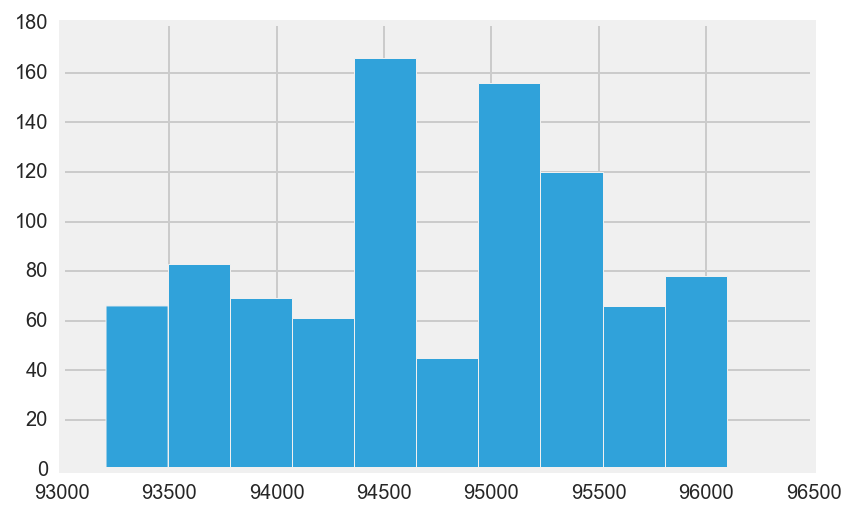

In [296]:
pge_q_num.ZipCode.hist()

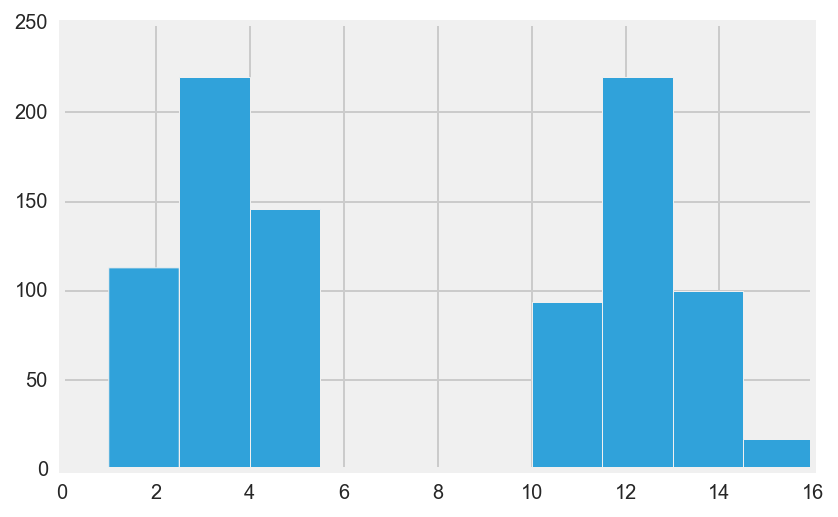

In [297]:
pge_q_num.zone.hist()

In [298]:
pge_q_num_corr  =  pge_q_num.corr()
pge_q_num_corr

,ZipCode,Month,Year,CustomerClass,Combined,TotalCustomers,TotalkWh,AveragekWh,zone,avg_temp,nameplate,cec,csi,cec_1_track,cec_2_track,csi_1_track,csi_2_track
ZipCode,1.000000,-0.046957,-0.024420,0.047163,NaN,-0.159079,-0.121581,-0.010201,0.080046,-0.376886,0.083150,0.083756,0.093268,0.100272,NaN,0.099554,NaN
Month,-0.046957,1.000000,-0.043318,0.056155,NaN,0.073582,0.086588,0.002846,0.020881,0.030486,-0.028087,-0.027366,-0.021362,-0.002308,NaN,-0.002193,NaN
Year,-0.024420,-0.043318,1.000000,-0.072376,NaN,-0.045447,-0.016483,0.091723,-0.006537,0.026381,0.008512,0.008633,0.020474,0.055045,NaN,0.054811,NaN
CustomerClass,0.047163,0.056155,-0.072376,1.000000,NaN,0.414281,-0.169050,-0.583178,0.148107,-0.034405,-0.027488,-0.027503,-0.030943,-0.030277,NaN,-0.030148,NaN
Combined,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TotalCustomers,-0.159079,0.073582,-0.045447,0.414281,NaN,1.000000,0.532705,-0.385556,-0.042894,0.097258,0.080663,0.080366,0.078147,0.052766,NaN,0.052470,NaN
TotalkWh,-0.121581,0.086588,-0.016483,-0.169050,NaN,0.532705,1.000000,0.266316,0.029822,0.209176,0.097963,0.097503,0.094459,0.063103,NaN,0.062768,NaN
AveragekWh,-0.010201,0.002846,0.091723,-0.583178,NaN,-0.385556,0.266316,1.000000,-0.039952,0.114353,0.030481,0.030358,0.031699,0.026605,NaN,0.026494,NaN
zone,0.080046,0.020881,-0.006537,0.148107,NaN,-0.042894,0.029822,-0.039952,1.000000,0.331573,-0.071345,-0.071267,-0.078379,-0.078529,NaN,-0.078195,NaN
avg_temp,-0.376886,0.030486,0.026381,-0.034405,NaN,0.097258,0.209176,0.114353,0.331573,1.000000,-0.085453,-0.086013,-0.092224,-0.089495,NaN,-0.089114,NaN


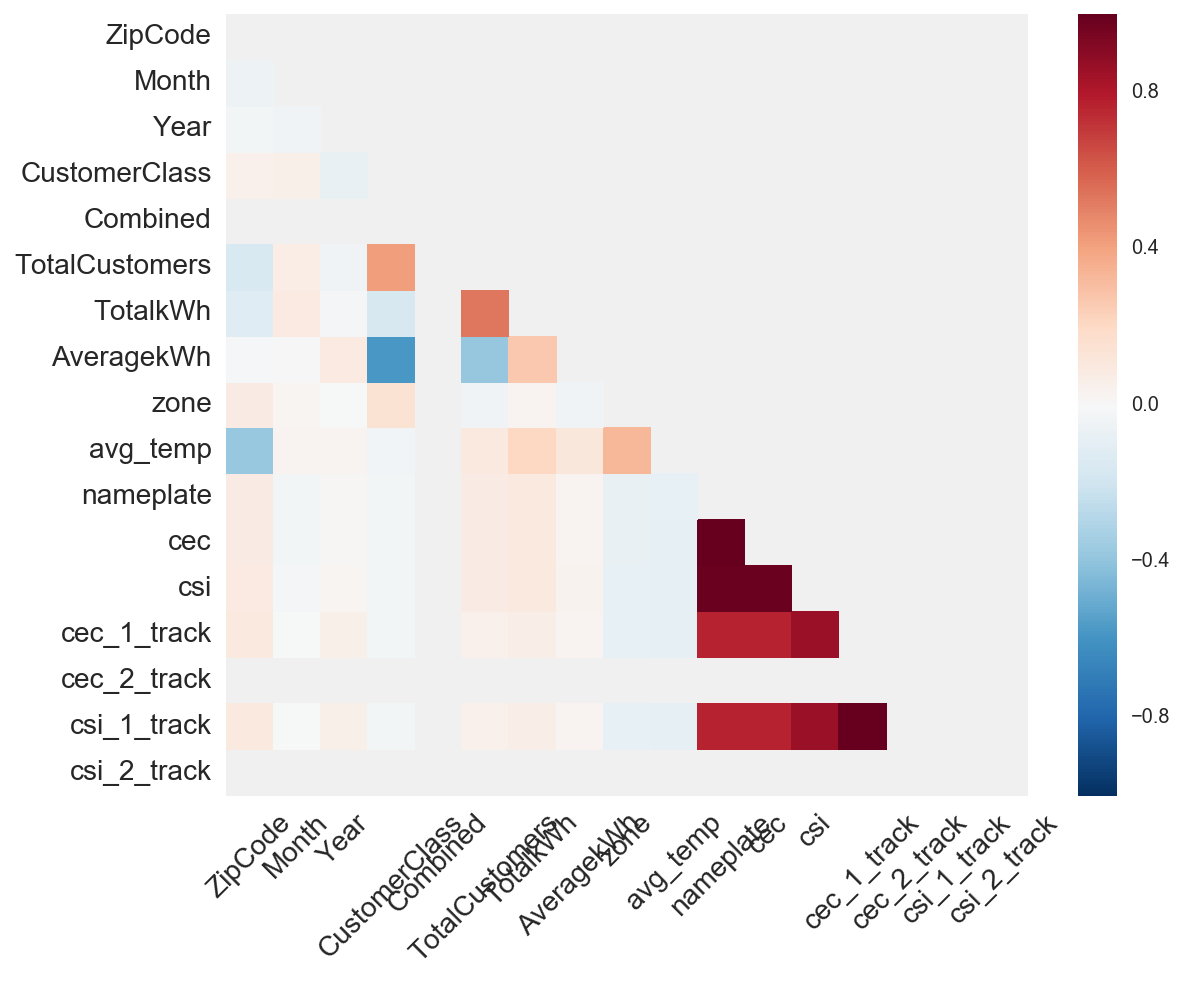

In [299]:
mask = np.zeros_like(pge_q_num_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(8,7))
ax = sns.heatmap(pge_q_num_corr, mask=mask)

ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=45)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)

plt.show()

Looking just at PG&E consumption data, we see that there is strong anti-correlation
between "TotalKWh" and "Month", and anti-corellation with "CustomerClass".

So interesting vars are TotalCustomers, TotalkWh, Month, zone, AveragekWh

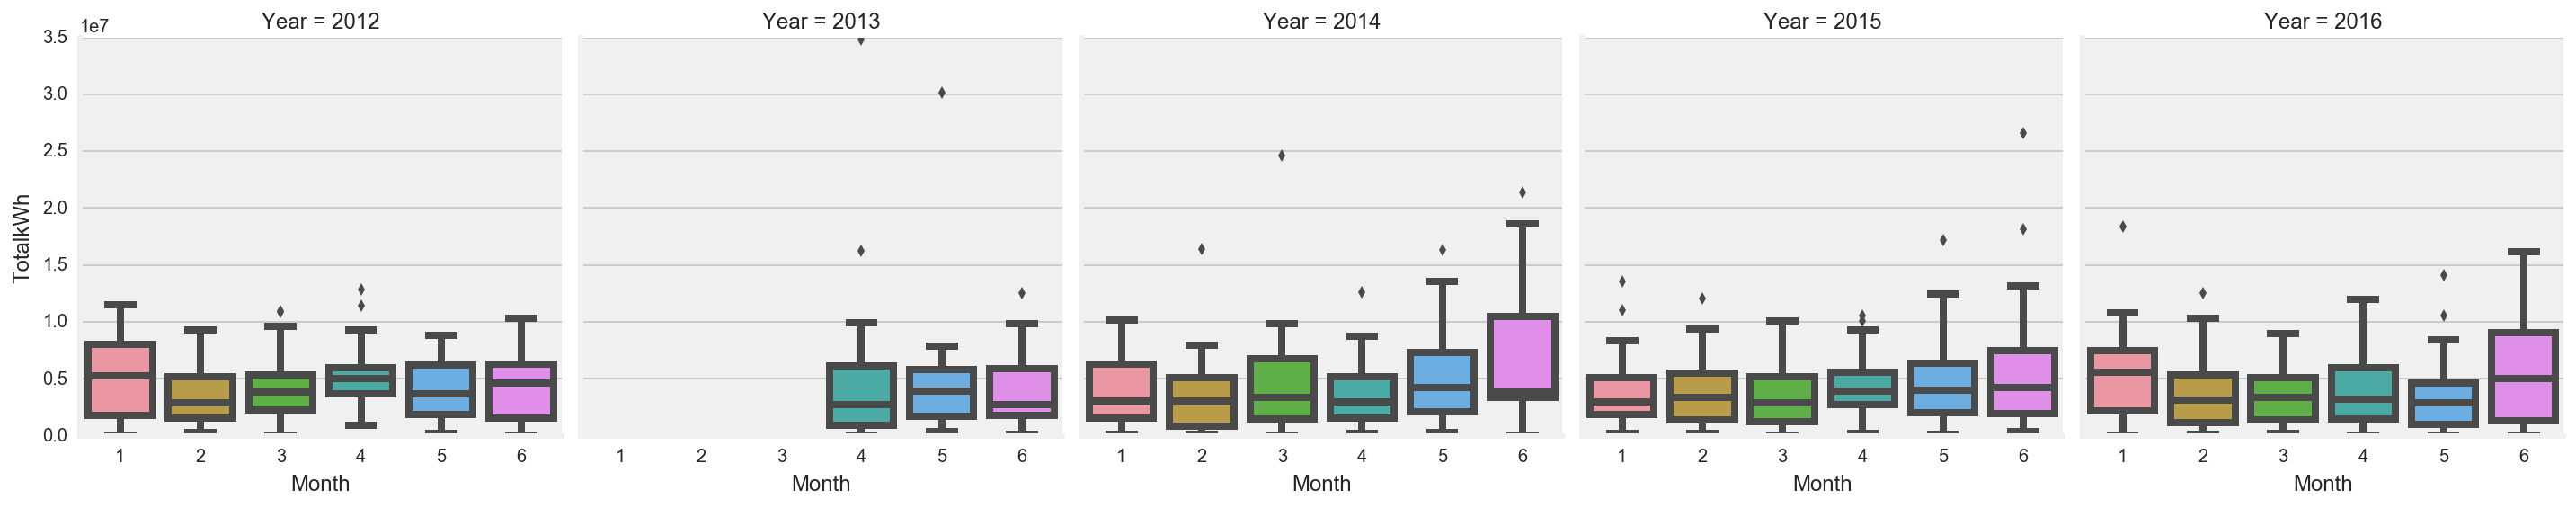

In [300]:
sns.factorplot(x='Month', y='TotalkWh',col='Year', kind='box', data=pge_q_num)

![](2.3.4.png)

Add avg_temp to the CA solar df

In [301]:
ca_solar_df_num['avg_temp'] = ca_solar_df_num['zone'].map(ca_2015_1_6_ave_dict)

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [302]:
ca_solar_df_num.dropna(inplace=True)

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


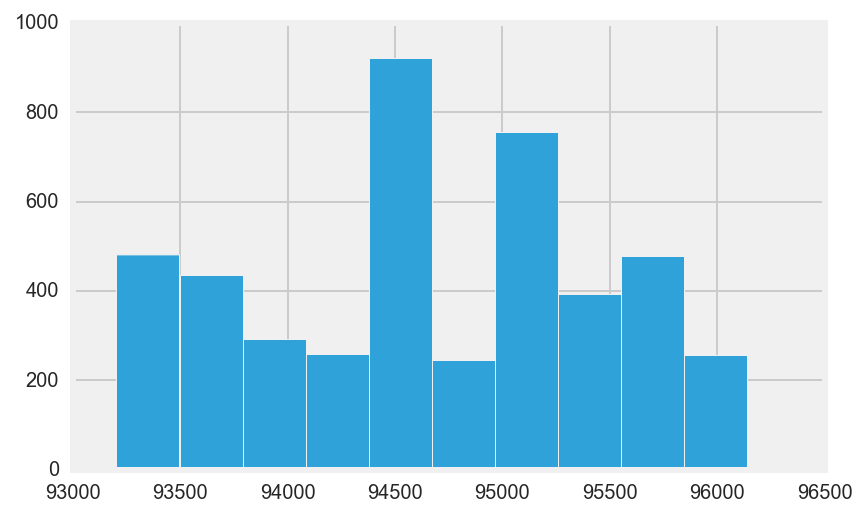

In [303]:
ca_solar_df_num.ZIP.hist()

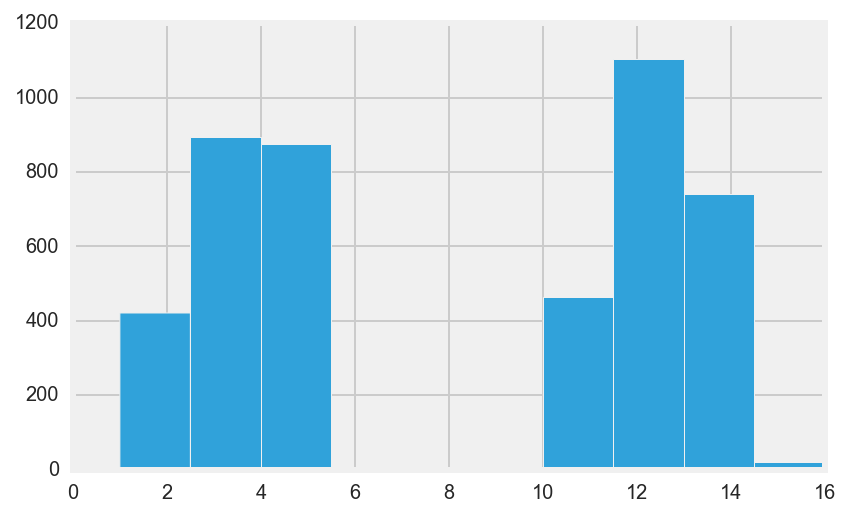

In [304]:
ca_solar_df_num.zone.hist()

In [305]:
ca_solar_df_num_corr  =  ca_solar_df_num.corr()
ca_solar_df_num_corr

,Nameplate_Rating,CEC_PTC_Rating,CSI_Rating,CEC_PTC_Rating_Single_Axis_Tracking,CEC_PTC_Rating_Dual_Axis_Tracking,CSI_Rating_Single_Axis_Tracking,CSI_Rating_Dual_Axis_Tracking,ZIP,zone,avg_temp
Nameplate_Rating,1.000000,0.999916,0.989775,0.748659,-0.002425,0.748148,-0.002424,-0.012646,0.029668,0.025622
CEC_PTC_Rating,0.999916,1.000000,0.989458,0.747349,-0.002448,0.746668,-0.002447,-0.012436,0.029894,0.025686
CSI_Rating,0.989775,0.989458,1.000000,0.829781,-0.002169,0.830551,-0.002169,-0.019431,0.033097,0.029042
CEC_PTC_Rating_Single_Axis_Tracking,0.748659,0.747349,0.829781,1.000000,-0.001001,0.999088,-0.001001,-0.029937,0.028739,0.028236
CEC_PTC_Rating_Dual_Axis_Tracking,-0.002425,-0.002448,-0.002169,-0.001001,1.000000,-0.000992,0.999991,0.003391,0.019553,-0.004842
CSI_Rating_Single_Axis_Tracking,0.748148,0.746668,0.830551,0.999088,-0.000992,1.000000,-0.000992,-0.031387,0.029769,0.029329
CSI_Rating_Dual_Axis_Tracking,-0.002424,-0.002447,-0.002169,-0.001001,0.999991,-0.000992,1.000000,0.003252,0.019569,-0.004709
ZIP,-0.012646,-0.012436,-0.019431,-0.029937,0.003391,-0.031387,0.003252,1.000000,-0.085527,-0.474160
zone,0.029668,0.029894,0.033097,0.028739,0.019553,0.029769,0.019569,-0.085527,1.000000,0.383332
avg_temp,0.025622,0.025686,0.029042,0.028236,-0.004842,0.029329,-0.004709,-0.474160,0.383332,1.000000


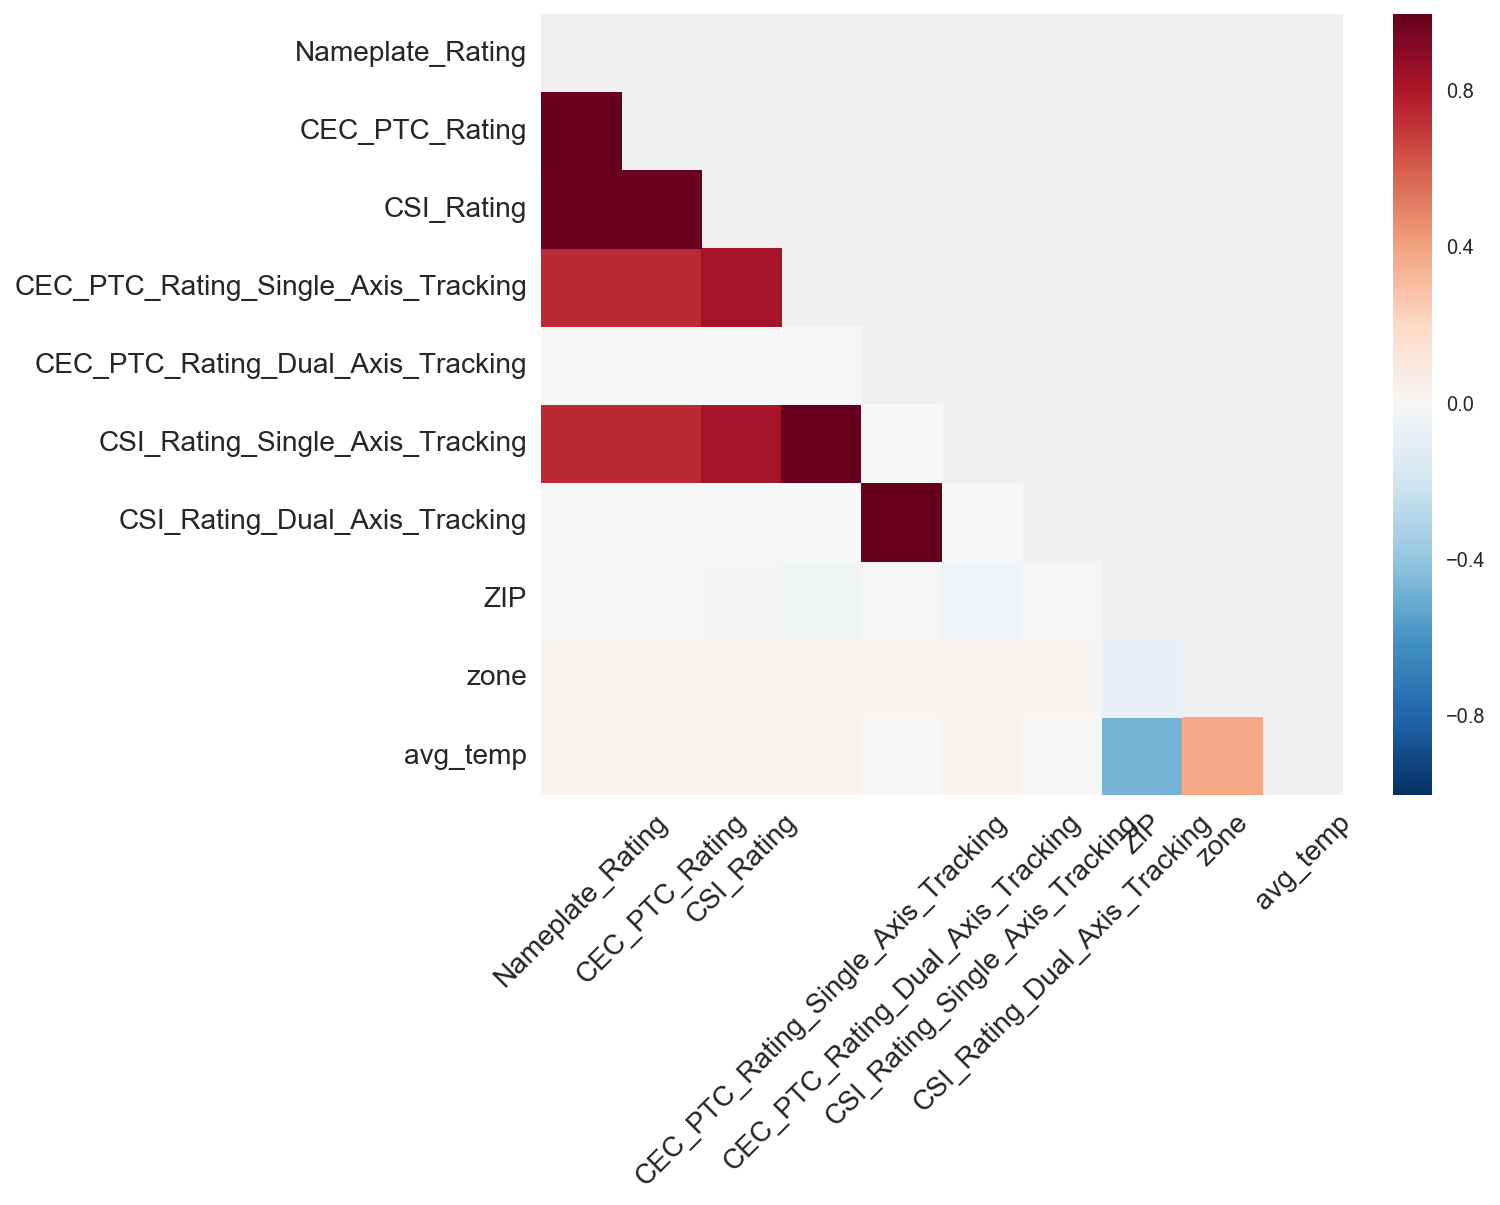

In [306]:
mask = np.zeros_like(ca_solar_df_num_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(8,7))
ax = sns.heatmap(ca_solar_df_num_corr, mask=mask)

ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=45)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)

plt.show()

So interesting vars are Nameplate Rating, CEC PTC Rating, CSI Rating, zone, avg_temp

<h2> 3. Let's do now some analysis. 
<br>
<br>
3.1 First, we do some linear regression. </h2>

In [308]:
target = 'TotalkWh'
non_target_cols = ['Month', 'TotalCustomers', 'ZipCode', 'CustomerClass', 'zone', 
                   'avg_temp']
#non_target_cols = ['AveragekWh', 'Month', 'TotalCustomers', 'CustomerClass', 'zone']
                   
#TotalCustomers, TotalkWh, Month, zone, AveragekWh
formula_simple = target + ' ~ ' + ' + '.join(non_target_cols) + ' -1'
print formula_simple

TotalkWh ~ Month + TotalCustomers + ZipCode + CustomerClass + zone + avg_temp -1


In [309]:
Y, X = patsy.dmatrices(formula_simple, data=pge_q_num)

In [310]:
simple_feature_names = X.design_info.column_names

In [311]:
pge_q_num.head(3)

,ZipCode,Month,Year,CustomerClass,Combined,TotalCustomers,TotalkWh,AveragekWh,zone,avg_temp,nameplate,cec,csi,cec_1_track,cec_2_track,csi_1_track,csi_2_track
6404,95252,3,2012,2,1,4367.0,3279187.0,751.0,12.0,57.166667,-2.40,-2.084,-2.057,-0.0,-0.0,-0.0,-0.0
6582,95215,3,2015,2,1,6439.0,3579054.0,556.0,12.0,57.166667,-16.77,-14.482,-14.141,-0.0,-0.0,-0.0,-0.0
1824,95460,1,2015,2,1,1050.0,740381.0,705.0,1.0,52.166667,-8.16,-6.931,-5.828,-0.0,-0.0,-0.0,-0.0


In [312]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
Xn = ss.fit_transform(pge_q_num)

In [313]:
linreg = LinearRegression()

linreg_scores = cross_val_score(linreg, Xn, Y, cv=10)

print linreg_scores
print np.mean(linreg_scores)

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
1.0


This score is too high. There must be some correlation between the vars.
Let me try a different formula, with categorical vars.

In [314]:
formula_simple = 'AveragekWh ~ C(TotalCustomers) + Month + Year + C(CustomerClass) + C(zone) + C(avg_temp) -1'
print formula_simple

AveragekWh ~ C(TotalCustomers) + Month + Year + C(CustomerClass) + C(zone) + C(avg_temp) -1


In [315]:
X, Y = patsy.dmatrices(formula_simple, data=pge_q_num)

In [316]:
simple_feature_names = X.design_info.column_names

In [317]:
ss = StandardScaler()
Xn = ss.fit_transform(pge_q_num)

In [318]:
linreg = LinearRegression()

linreg_scores = cross_val_score(linreg, Xn, Y, cv=10)

print linreg_scores
print np.mean(linreg_scores)
linreg_fit = linreg.fit(Xn, Y)

[ 0.73807917  0.74511042  0.7276779   0.7614213   0.7665163   0.7427728
  0.72920543  0.76672467  0.76387831  0.7148828 ]
0.745626909698


This is more reasonable. The AWS result is 
<pre>
[ 0.41476044  0.41889318  0.75286632  0.4200982   0.73609376  0.44542479
  0.42138057  0.42063523  0.50239673  0.43774385]
0.497029308677
</pre>

<h2> 3.2 Now Ridge with cross-validation </h2>

In [319]:
ridge_alphas = np.logspace(0, 5, 200)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(Xn, Y)

print optimal_ridge.alpha_

2.83309610184


In [320]:
ridge = Ridge(alpha=optimal_ridge.alpha_)

ridge_scores = cross_val_score(ridge, Xn, Y, cv=10)

print ridge_scores
print np.mean(ridge_scores)

[ 0.73791602  0.74596377  0.72778641  0.76206735  0.76730177  0.74223777
  0.72885497  0.76776451  0.7629579   0.71552323]
0.745837367715


OK,  Ridge gives now good answers w cross validation. 

<h2> 3.3 Let's plot the results.  </h2>

In [321]:

def ridge_coefs(X, Y, alphas):
    
    # set up the list to hold the different sets of coefficients:
    coefs = []
    
    # Set up a ridge regression object
    ridge_reg = Ridge()


    # Iterate through the alphas fed into the function:
    for a in alphas:
        
        # On each alpha reset the ridge model's alpha to the current one:
        ridge_reg.set_params(alpha=a)        
        
        # fit or refit the model on the provided X, Y
        ridge_reg.fit(X, Y)
        
        # Get out the coefficient list (first element of the .coef_ attribute)
        coefs.append(ridge_reg.coef_[0])
        
    return coefs

In [322]:
from cycler import cycler

def coef_plotter(alphas, coefs, feature_names, to_alpha, regtype='ridge'):
    
    # Get the full range of alphas before subsetting to keep the plots from 
    # resetting axes each time. (We use these values to set static axes later).
    amin = np.min(alphas)
    amax = np.max(alphas)
    
    # Subset the alphas and coefficients to just the ones below the set limit
    # from the interactive widget:
    alphas = [a for a in alphas if a <= to_alpha]
    coefs = coefs[0:len(alphas)]
    
    # Get some colors from seaborn:
    colors = sns.color_palette("husl", len(coefs[0]))
    
    # Get the figure and reset the size to be wider:
    fig = plt.figure()
    fig.set_size_inches(18,7)

    # We have two axes this time on our figure. 
    # The fig.add_subplot adds axes to our figure. The number inside stands for:
    #[figure_rows|figure_cols|position_of_current_axes]
    ax1 = fig.add_subplot(121)
    
    # Give it the color cycler:
    ax1.set_prop_cycle(cycler('color', colors))
    
    # Print a vertical line showing our current alpha threshold:
    ax1.axvline(to_alpha, lw=2, ls='dashed', c='k', alpha=0.4)
    
    # Plot the lines of the alphas on x-axis and coefficients on y-axis
    ax1.plot(alphas, coefs, lw=2)
    
    # set labels for axes:
    ax1.set_xlabel('alpha', fontsize=20)
    ax1.set_ylabel('coefficients', fontsize=20)
    
    # If this is for the ridge, set this to a log scale on the x-axis:
    if regtype == 'ridge':
        ax1.set_xscale('log')
    
    # Enforce the axis limits:
    ax1.set_xlim([amin, amax])
    
    # Put a title on the axis
    ax1.set_title(regtype+' coef paths\n', fontsize=20)
    
    # Get the ymin and ymax for this axis to enforce it to be the same on the 
    # second chart:
    ymin, ymax = ax1.get_ylim()

    # Add our second axes for the barplot in position 2:
    ax2 = fig.add_subplot(122)
    
    # Position the bars according to their index from the feature names variable:
    ax2.bar(range(1, len(feature_names)+1), coefs[-1], align='center', color=colors)
    ax2.set_xticks(range(1, len(feature_names)+1))
    
    # Reset the ticks from numbers to acutally be the names:
    ax2.set_xticklabels(feature_names, rotation=65, fontsize=12)
    
    # enforce limits and add titles, labels
    ax2.set_ylim([ymin, ymax])
    ax2.set_title(regtype+' predictor coefs\n', fontsize=20)
    ax2.set_xlabel('coefficients', fontsize=20)
    ax2.set_ylabel('alpha', fontsize=20)
    
    plt.show()

In [323]:
r_alphas = np.logspace(0, 5, 200)

# Get the coefficients for each alpha for the Ridge, using the function above
r_coefs = ridge_coefs(X, Y, r_alphas)

In [324]:
from ipywidgets import *
from IPython.display import display

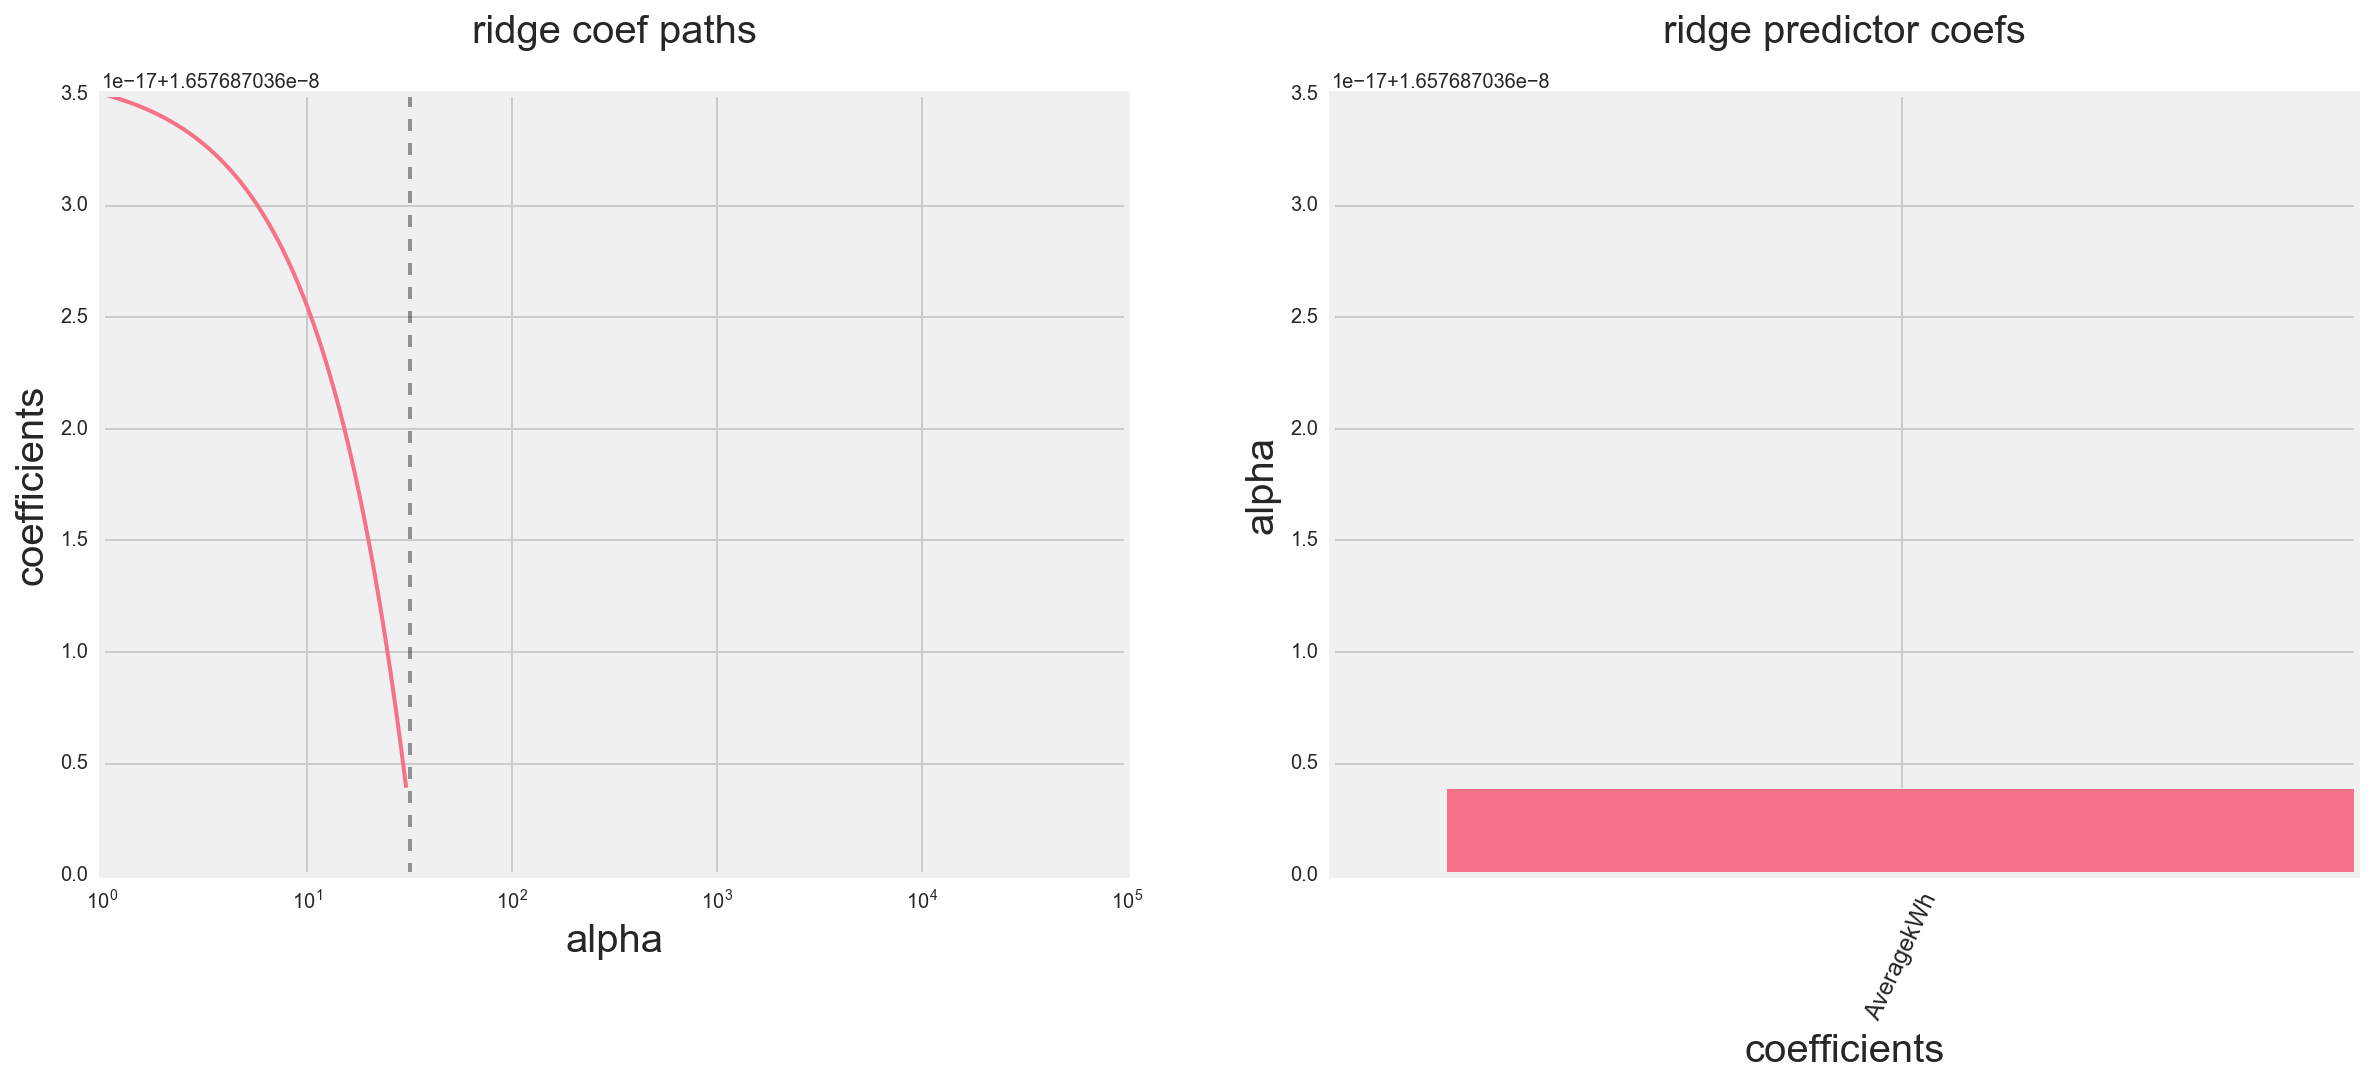

<function __main__.ridge_plot_runner>

In [325]:
def ridge_plot_runner(log_of_alpha=1.5):
    coef_plotter(r_alphas, r_coefs, simple_feature_names, 10**log_of_alpha, regtype='ridge')

interact(ridge_plot_runner, log_of_alpha=(0.0,5.0,0.05))

Since I did not get a good analysis with Ridge, I will go now to Elastic Net. 

<h2> 3.4 Let's look at ElasticNet now.  </h2>

In [335]:
target = 'TotalkWh'
non_target_cols = ['AveragekWh', 'Month', 'TotalCustomers', 'ZipCode', 'CustomerClass', 'zone', 
                   'avg_temp']                   
formula_simple = target + ' ~ ' + ' + '.join(non_target_cols) + ' -1'
print formula_simple

TotalkWh ~ AveragekWh + Month + TotalCustomers + ZipCode + CustomerClass + zone + avg_temp -1


In [336]:
Y, X = patsy.dmatrices(formula_simple, data=pge_q_num)

In [337]:
simple_feature_names = X.design_info.column_names

In [430]:
def elasticnet_coefs(X, Y, alphas):
    coefs = []
    score = []
    l1_ratios = alphas

    #enet_reg = ElasticNetCV()
    enet_reg = ElasticNet()
    for a in alphas:
        #enet_reg.set_params(l1_ratio=l1_ratios, n_alphas=100, cv=5,verbose=1)
        enet_reg.set_params(alpha=a, l1_ratio=0.05)
        enet_reg.fit(X, Y)
        score.append(enet_reg.score(X,Y))
        coefs.append(enet_reg.coef_)
        
    return np.mean(score), coefs

In [431]:
enet_alphas = np.arange(0, 3.0, 0.05)
enet_score, enet_coefs = elasticnet_coefs(X, Y, enet_alphas)

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:11: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator


In [432]:
print "enet score is: ", enet_score

enet score is:  0.565660249521


Not great, but not too bad. 

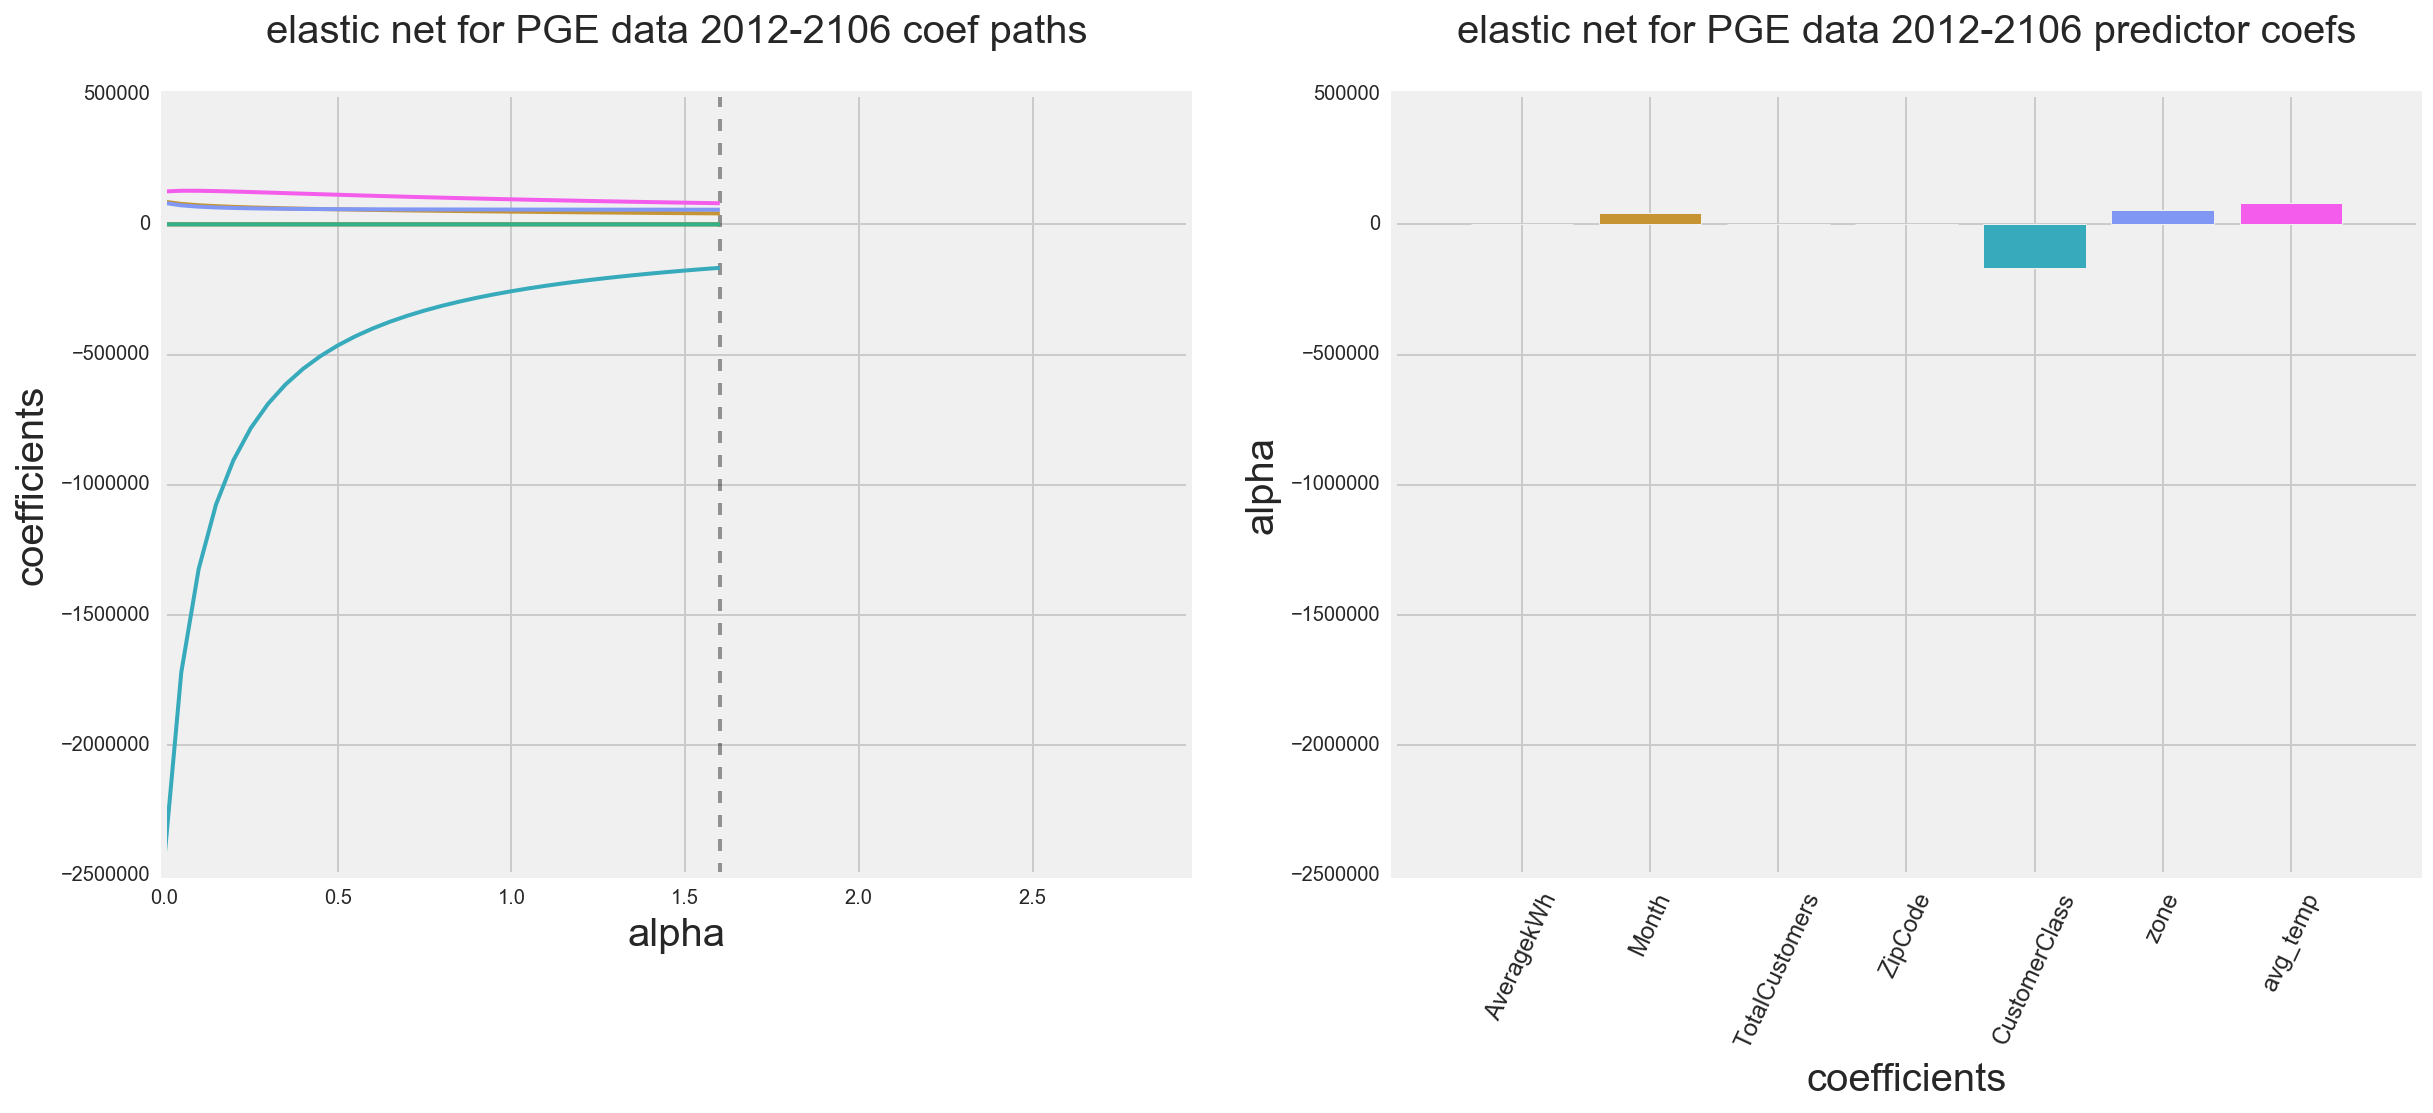

<function __main__.enet_plot_runner>

In [340]:
def enet_plot_runner(alpha=1.60):
    coef_plotter(enet_alphas, enet_coefs, simple_feature_names, alpha, 
                 regtype='elastic net for PGE data 2012-2106')

interact(enet_plot_runner, alpha=(0.0,3.0,0.05))

![](3.4.1.2.png)

Looking just at PG&E consumption data, we see that 'TotalkWh' correlates with "zone" and "avg_temp" anti-correlation between "TotalKWh" and "Month", and anti-corellation with "CustomerClass".

This result seems  good. Let me do a time series analysis, see if we get as good are result there.
The data is monthly, Jan - Jun for 5 years, 2012-2016, so it might be ameanable to time series analysis. 

<h2> 3.5 Time series analysis. </h2>

In [341]:
avgkwh_diff  = pge_q_num.AveragekWh.diff()

In [342]:
avgkwh_diff.dropna(inplace=True)

In [343]:
totalkwh_diff = pge_q_num.TotalkWh.diff()

In [344]:
totalkwh_diff.dropna(inplace=True)

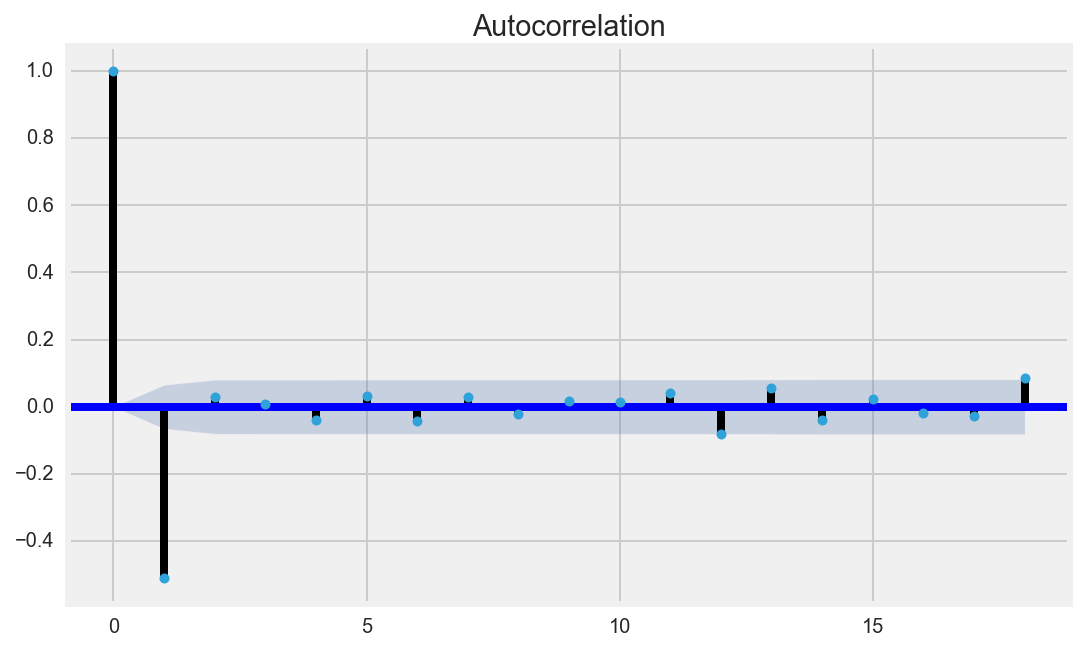

In [345]:
# pick the lag value at 18 = 6 * 3 the total number of data points we have for each avg kwh, total kwh
fig = plt.figure(figsize=(8,5))
ax = fig.gca()
plot_acf(avgkwh_diff, lags=18, ax=ax)
plt.show()

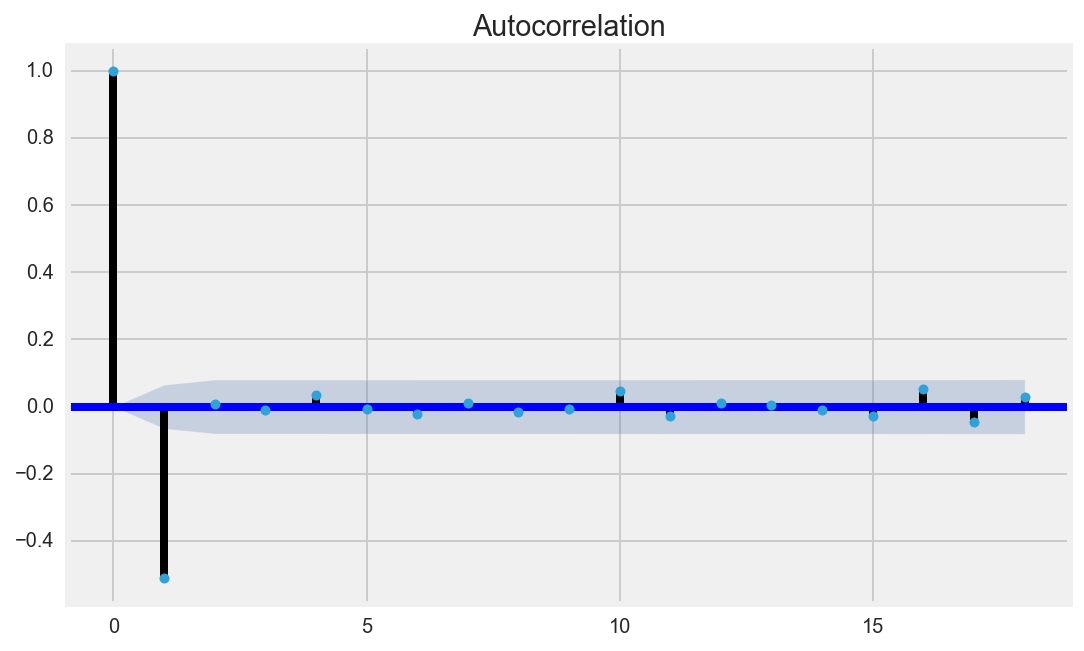

In [346]:
fig = plt.figure(figsize=(8,5))
ax = fig.gca()
plot_acf(totalkwh_diff, lags=18, ax=ax)
plt.show()

In [347]:
ar1 = ARMA(avgkwh_diff.values, (1,0)).fit()
ar1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  909
Model:                     ARMA(1, 0)   Log Likelihood               -9033.297
Method:                       css-mle   S.D. of innovations           5006.620
Date:                Mon, 10 Oct 2016   AIC                          18072.595
Time:                        10:53:22   BIC                          18087.032
Sample:                             0   HQIC                         18078.107
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -0.2329    109.967     -0.002      0.998      -215.763   215.298
ar.L1.y       -0.5106      0.028    -17.924      0.000        -0.566    -0.455
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.9583           +0.0000j            1.9583            0.5000
-----------------------------------------------------------------------------
"""

In [348]:
ar2 = ARMA(totalkwh_diff.values, (1,0)).fit()
ar2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  909
Model:                     ARMA(1, 0)   Log Likelihood              -15252.646
Method:                       css-mle   S.D. of innovations        4687843.206
Date:                Mon, 10 Oct 2016   AIC                          30511.291
Time:                        10:53:22   BIC                          30525.728
Sample:                             0   HQIC                         30516.804
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const      -2332.6766   1.03e+05     -0.023      0.982     -2.04e+05  1.99e+05
ar.L1.y       -0.5111      0.028    -17.947      0.000        -0.567    -0.455
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.9567           +0.0000j            1.9567            0.5000
-----------------------------------------------------------------------------
"""

In [349]:
r2_score(avgkwh_diff, ar1.fittedvalues)

0.26120237425220105

On AWS, I get: 0.46362425034127097

In [350]:
r2_score(totalkwh_diff, ar2.fittedvalues)

0.26168987283602052

On AWS, I get: 0.21200243459953971

These results are not as high as the linear regression, but are probably more realistic.

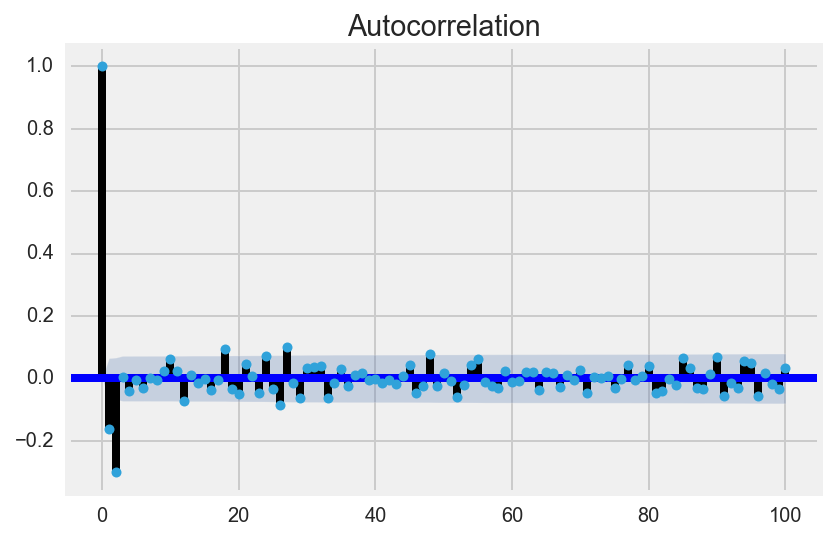

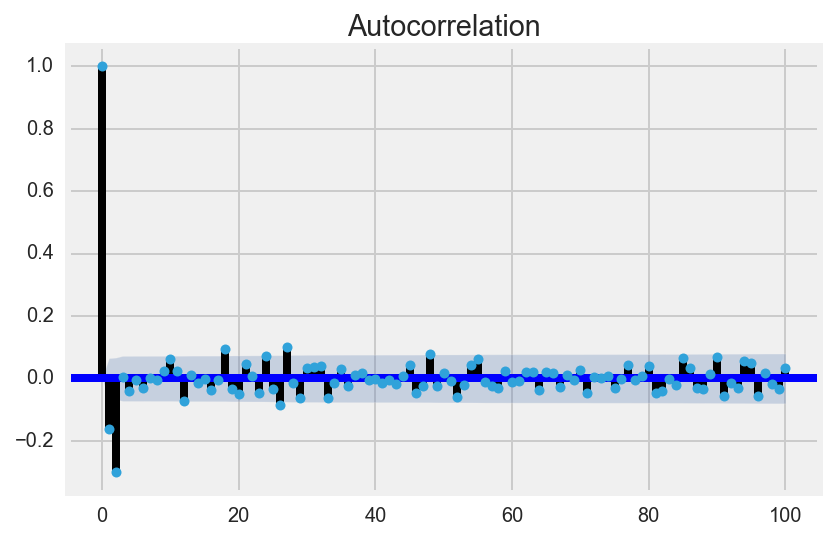

In [351]:
plot_acf(ar1.resid, lags=100)

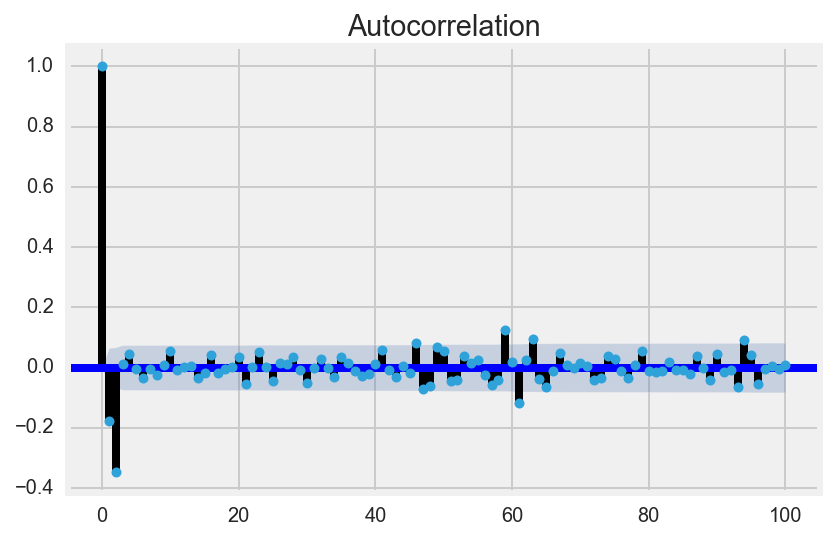

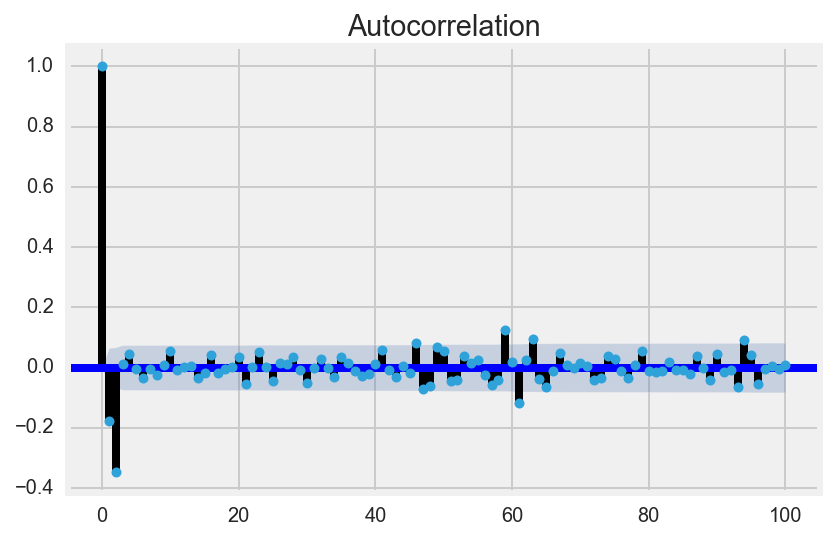

In [352]:
plot_acf(ar2.resid, lags=100)

These plots show values close to 0 onthe y-axis, so they are trust-worthy. 

The auto-correlation plots look Ok also.

<h2> 4. Let's turn now to the solar data analysis. </h2>

In [353]:
ca_solar_df_num_corr  =  ca_solar_df_num.corr()
ca_solar_df_num_corr

,Nameplate_Rating,CEC_PTC_Rating,CSI_Rating,CEC_PTC_Rating_Single_Axis_Tracking,CEC_PTC_Rating_Dual_Axis_Tracking,CSI_Rating_Single_Axis_Tracking,CSI_Rating_Dual_Axis_Tracking,ZIP,zone,avg_temp
Nameplate_Rating,1.000000,0.999916,0.989775,0.748659,-0.002425,0.748148,-0.002424,-0.012646,0.029668,0.025622
CEC_PTC_Rating,0.999916,1.000000,0.989458,0.747349,-0.002448,0.746668,-0.002447,-0.012436,0.029894,0.025686
CSI_Rating,0.989775,0.989458,1.000000,0.829781,-0.002169,0.830551,-0.002169,-0.019431,0.033097,0.029042
CEC_PTC_Rating_Single_Axis_Tracking,0.748659,0.747349,0.829781,1.000000,-0.001001,0.999088,-0.001001,-0.029937,0.028739,0.028236
CEC_PTC_Rating_Dual_Axis_Tracking,-0.002425,-0.002448,-0.002169,-0.001001,1.000000,-0.000992,0.999991,0.003391,0.019553,-0.004842
CSI_Rating_Single_Axis_Tracking,0.748148,0.746668,0.830551,0.999088,-0.000992,1.000000,-0.000992,-0.031387,0.029769,0.029329
CSI_Rating_Dual_Axis_Tracking,-0.002424,-0.002447,-0.002169,-0.001001,0.999991,-0.000992,1.000000,0.003252,0.019569,-0.004709
ZIP,-0.012646,-0.012436,-0.019431,-0.029937,0.003391,-0.031387,0.003252,1.000000,-0.085527,-0.474160
zone,0.029668,0.029894,0.033097,0.028739,0.019553,0.029769,0.019569,-0.085527,1.000000,0.383332
avg_temp,0.025622,0.025686,0.029042,0.028236,-0.004842,0.029329,-0.004709,-0.474160,0.383332,1.000000


In [354]:
ca_solar_df_num.head(3)

,Nameplate_Rating,CEC_PTC_Rating,CSI_Rating,CEC_PTC_Rating_Single_Axis_Tracking,CEC_PTC_Rating_Dual_Axis_Tracking,CSI_Rating_Single_Axis_Tracking,CSI_Rating_Dual_Axis_Tracking,ZIP,zone,avg_temp
42006,8.16,7.014,6.795,0.0,0.0,0.0,0.0,95132,4.0,57.500000
118,3.00,2.608,2.376,0.0,0.0,0.0,0.0,95070,4.0,57.500000
25094,10.92,9.491,9.226,0.0,0.0,0.0,0.0,94551,12.0,57.166667


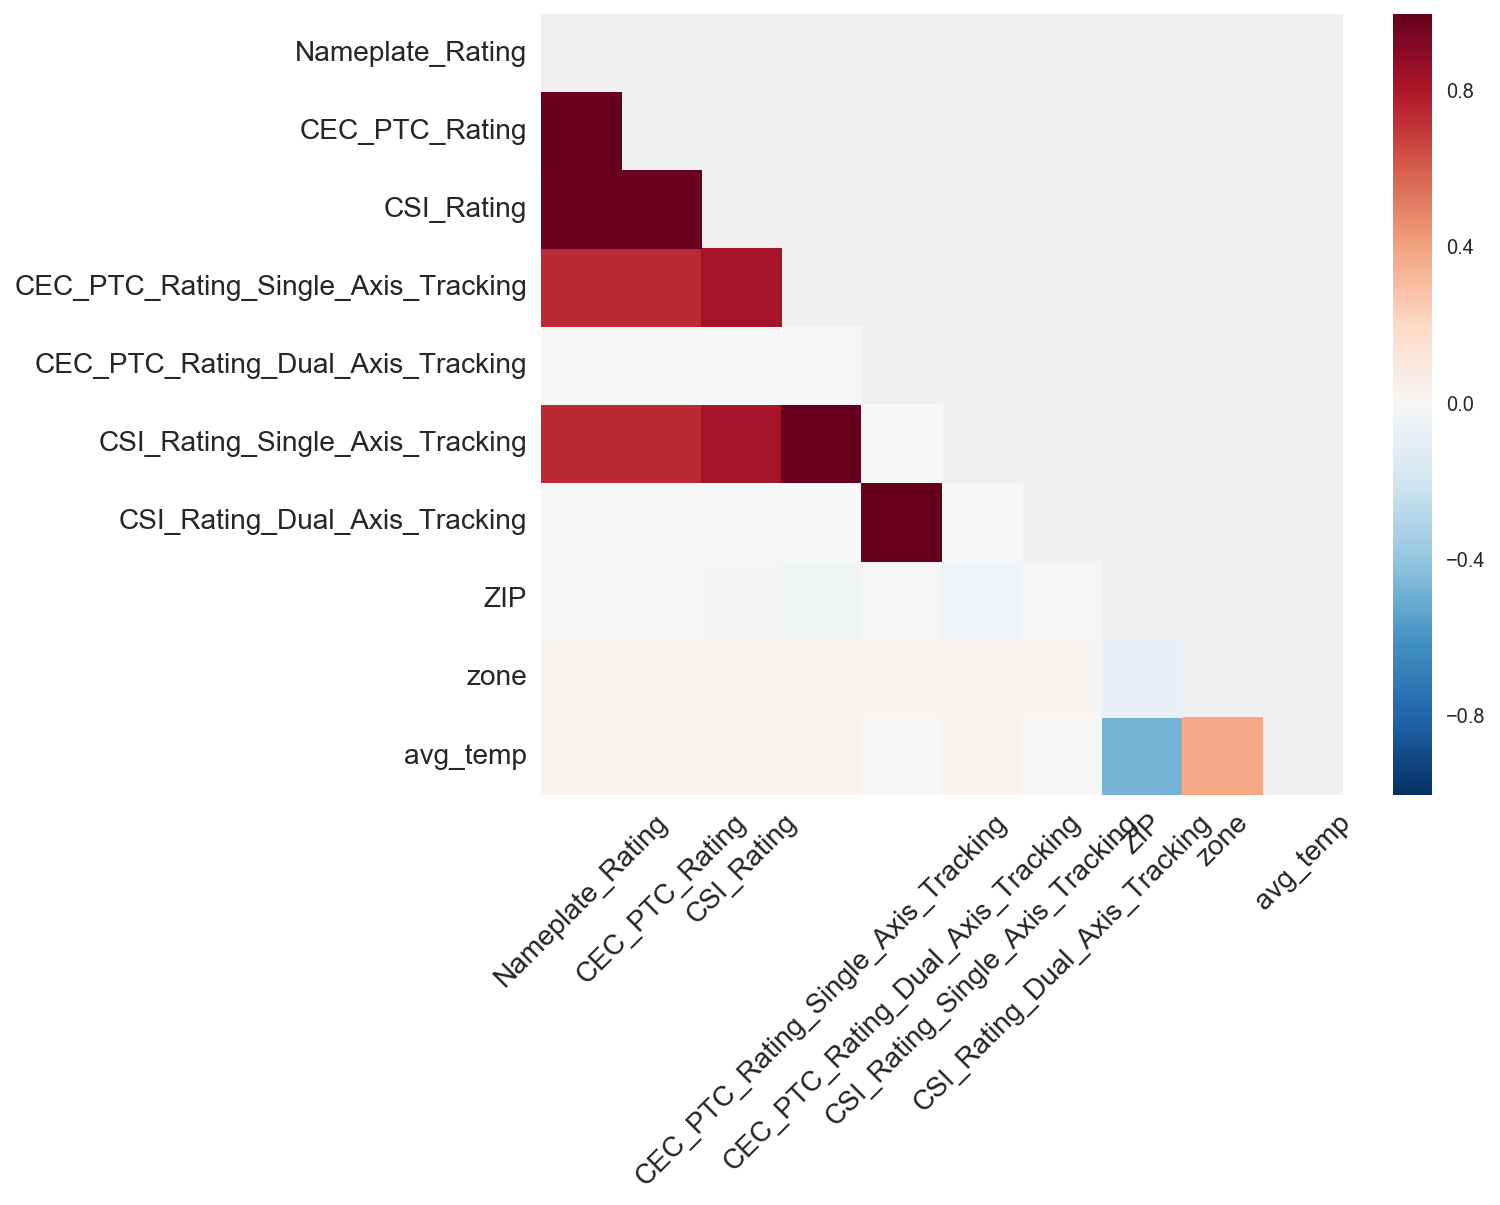

In [355]:
mask = np.zeros_like(ca_solar_df_num_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(8,7))
ax = sns.heatmap(ca_solar_df_num_corr, mask=mask)

ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=45)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)

plt.show()

So interesting vars are Nameplate Rating, CEC PTC Rating, CSI Rating, zone, avg_temp

<h2> 4.1 Some linear regression on CA solar data now. </h2>

In [356]:
target1 = 'CEC_PTC_Rating'
target1 = 'CSI_Rating'
non_target_cols1 = ['Nameplate_Rating', 'CEC_PTC_Rating', 'CEC_PTC_Rating_Single_Axis_Tracking',
                   'CEC_PTC_Rating_Dual_Axis_Tracking', 'CSI_Rating_Single_Axis_Tracking', 
                    'CSI_Rating_Dual_Axis_Tracking', 'ZIP', 'zone', 'avg_temp']
formula_simple1 = target1 + ' ~ ' + ' + '.join(non_target_cols1) + ' -1'
print formula_simple1

CSI_Rating ~ Nameplate_Rating + CEC_PTC_Rating + CEC_PTC_Rating_Single_Axis_Tracking + CEC_PTC_Rating_Dual_Axis_Tracking + CSI_Rating_Single_Axis_Tracking + CSI_Rating_Dual_Axis_Tracking + ZIP + zone + avg_temp -1


In [357]:
ss1 = StandardScaler()
X1_n = ss.fit_transform(ca_solar_df_num)

In [358]:
Y1, X1 = patsy.dmatrices(formula_simple1, data=ca_solar_df_num)

In [359]:
X1_n.shape, Y1.shape

((4518, 10), (4518, 1))

In [360]:
linreg1 = LinearRegression()

linreg_scores1 = cross_val_score(linreg1, X1_n, Y1, cv=10)

print linreg_scores1
print np.mean(linreg_scores1)

[ 1.          1.          1.          1.          1.          0.99999966
  0.99999339  1.          1.          1.        ]
0.999999305606


As in the case for PGE data, this impossibly good score means that I need to change the analysis formula and try Ridge.

<h2> 4.2 Ridge regression with cross-validation. </h2>

In [361]:
simple_formula1 = 'C(Nameplate_Rating) ~  CEC_PTC_Rating + CEC_PTC_Rating_Single_Axis_Tracking + \
                    CSI_Rating_Dual_Axis_Tracking +CSI_Rating_Single_Axis_Tracking + ZIP + C(zone)  + C(avg_temp) -1'
print simple_formula1

C(Nameplate_Rating) ~  CEC_PTC_Rating + CEC_PTC_Rating_Single_Axis_Tracking +                     CSI_Rating_Dual_Axis_Tracking +CSI_Rating_Single_Axis_Tracking + ZIP + C(zone)  + C(avg_temp) -1


In [362]:
Y1, X1 = patsy.dmatrices(simple_formula1, data=ca_solar_df_num)

In [363]:
ss1 = StandardScaler()
X1_n = ss.fit_transform(ca_solar_df_num)

In [364]:
ridge_alphas1 = np.logspace(0, 5, 200)

optimal_ridge1 = RidgeCV(alphas=ridge_alphas1, cv=5)
optimal_ridge1.fit(X1_n, Y1)

print optimal_ridge1.alpha_

9329.30402628


In [365]:
ridge1 = Ridge(alpha=optimal_ridge1.alpha_)

ridge_scores1 = cross_val_score(ridge1, X1_n, Y1, cv=10)

print ridge_scores1
print np.mean(ridge_scores1)

[-0.00180927 -0.00165458 -0.00171266 -0.00143556 -0.00167342 -0.0023693
 -0.00197227 -0.0018658  -0.00167004 -0.00167685]
-0.00178397597078


Ridge regression did not work. Let me run Stochastic Gradient Descent.

<h2> 4.3 Stochastic Gradient Descent. </h2>

In [366]:
target1 = 'Nameplate_Rating'
non_target_cols1 = ['CSI_Rating', 'CEC_PTC_Rating', 'CEC_PTC_Rating_Single_Axis_Tracking',
                   'CEC_PTC_Rating_Dual_Axis_Tracking', 'CSI_Rating_Single_Axis_Tracking', 
                    'CSI_Rating_Dual_Axis_Tracking', 'ZIP', 'zone', 'avg_temp']

formula_simple1 = target1 + ' ~ ' + ' + '.join(non_target_cols1) + ' -1'
print formula_simple1

Nameplate_Rating ~ CSI_Rating + CEC_PTC_Rating + CEC_PTC_Rating_Single_Axis_Tracking + CEC_PTC_Rating_Dual_Axis_Tracking + CSI_Rating_Single_Axis_Tracking + CSI_Rating_Dual_Axis_Tracking + ZIP + zone + avg_temp -1


In [367]:
ss1 = StandardScaler()
X1_n = ss.fit_transform(ca_solar_df_num)

In [416]:
Y1, X1 = patsy.dmatrices(formula_simple1, data=ca_solar_df_num)

In [369]:
simple_feature_names1 = X1.design_info.column_names

In [420]:
sgd_params1 = {
    'loss':['squared_loss'],
    'penalty':['l1','l2'],
    'alpha':np.linspace(0.01, 10000, 100)
}

sgd_reg1 = SGDRegressor()
sgd_reg_gs1 = GridSearchCV(sgd_reg1, sgd_params1, cv=5, verbose=2)

In [421]:
sgd_reg_gs1.fit(X1_n, Y1)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV] penalty=l1, alpha=0.01, loss=squared_loss .......................
[CV] .............. penalty=l1, alpha=0.01, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=0.01, loss=squared_loss .......................
[CV] .............. penalty=l1, alpha=0.01, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=0.01, loss=squared_loss .......................
[CV] .............. penalty=l1, alpha=0.01, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=0.01, loss=squared_loss .......................
[CV] .............. penalty=l1, alpha=0.01, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=0.01, loss=squared_loss .......................
[CV] .............. penalty=l1, alpha=0.01, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=0.01, loss=squared_loss .......................
[CV] .............. penalty=l2, alpha=0.01, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=0.01, loss=squared_loss .......................
[CV] ........

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ............ penalty=l1, alpha=202.03, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=202.03, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=202.03, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=202.03, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=202.03, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=202.03, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=202.03, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=202.03, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=202.03, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=202.03, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=202.03, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=202.03, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=202.03, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=303.04, loss=squared_loss .....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ............ penalty=l2, alpha=404.05, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=404.05, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=404.05, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=404.05, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=404.05, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=404.05, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=404.05, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=404.05, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=404.05, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=505.06, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=505.06, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=505.06, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=505.06, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=505.06, loss=squared_loss .....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ............ penalty=l1, alpha=707.08, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=707.08, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=707.08, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=707.08, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=707.08, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=707.08, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=707.08, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=707.08, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=707.08, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=707.08, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=707.08, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=707.08, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=707.08, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=707.08, loss=squared_loss .....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] penalty=l2, alpha=1212.13, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=1212.13, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=1212.13, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=1212.13, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=1212.13, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=1212.13, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=1212.13, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=1212.13, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=1212.13, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=1212.13, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=1313.14, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=1313.14, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=1313.14, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=1313.14, loss=squared_loss -   0.0s
[CV] p

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l2, alpha=1414.15, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=1414.15, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=1414.15, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=1515.16, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=1515.16, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=1515.16, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=1515.16, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=1515.16, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=1515.16, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=1515.16, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=1515.16, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=1515.16, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=1515.16, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=1515.16, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l1, alpha=1717.18, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=1717.18, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=1717.18, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=1717.18, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=1717.18, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=1717.18, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=1717.18, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=1717.18, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=1717.18, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=1717.18, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=1717.18, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=1717.18, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=1717.18, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=1717.18, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ............ penalty=l1, alpha=1919.2, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=1919.2, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=1919.2, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=1919.2, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=1919.2, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=1919.2, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=1919.2, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=1919.2, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=1919.2, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=1919.2, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=1919.2, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=2020.21, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=2020.21, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=2020.21, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l2, alpha=2121.22, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=2222.23, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=2222.23, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=2222.23, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=2222.23, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=2222.23, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=2222.23, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=2222.23, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=2222.23, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=2222.23, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=2222.23, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=2222.23, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=2222.23, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=2222.23, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l2, alpha=2323.24, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=2424.25, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=2424.25, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=2424.25, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=2424.25, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=2424.25, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=2424.25, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=2424.25, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=2424.25, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=2424.25, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=2424.25, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=2424.25, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=2424.25, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=2424.25, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l1, alpha=2727.28, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=2727.28, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=2727.28, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=2727.28, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=2727.28, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=2727.28, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=2727.28, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=2727.28, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=2727.28, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=2727.28, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=2727.28, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=2828.29, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=2828.29, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=2828.29, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ............ penalty=l2, alpha=2929.3, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=2929.3, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=2929.3, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=2929.3, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=2929.3, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=2929.3, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=2929.3, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=2929.3, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=2929.3, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=3030.31, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=3030.31, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=3030.31, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=3030.31, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=3030.31, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l1, alpha=3131.32, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=3131.32, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=3131.32, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=3131.32, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=3131.32, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=3131.32, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=3131.32, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=3131.32, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=3131.32, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=3131.32, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=3131.32, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=3131.32, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=3131.32, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=3131.32, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] penalty=l1, alpha=3333.34, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=3333.34, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=3333.34, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=3333.34, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=3333.34, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=3333.34, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=3333.34, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=3333.34, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=3333.34, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=3333.34, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=3333.34, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=3333.34, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=3333.34, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=3333.34, loss=squared_loss -   0.0s
[CV] p

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l1, alpha=3535.36, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=3535.36, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=3535.36, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=3535.36, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=3535.36, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=3535.36, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=3535.36, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=3535.36, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=3535.36, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=3535.36, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=3535.36, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=3535.36, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=3535.36, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=3535.36, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l1, alpha=3737.38, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=3737.38, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=3737.38, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=3737.38, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=3737.38, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=3737.38, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=3737.38, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=3737.38, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=3737.38, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=3737.38, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=3737.38, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=3737.38, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=3737.38, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=3737.38, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] penalty=l1, alpha=3939.4, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=3939.4, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=3939.4, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=3939.4, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=3939.4, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=3939.4, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=3939.4, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=3939.4, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=3939.4, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=3939.4, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=3939.4, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=3939.4, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=4040.41, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=4040.41, loss=squared_loss -   0.0s
[CV] p

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] penalty=l2, alpha=4141.42, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=4141.42, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=4141.42, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=4141.42, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=4141.42, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=4141.42, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=4242.43, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=4242.43, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=4242.43, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=4242.43, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=4242.43, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=4242.43, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=4242.43, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=4242.43, loss=squared_loss -   0.0s
[CV] p

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] penalty=l1, alpha=4343.44, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=4343.44, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=4343.44, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=4343.44, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=4343.44, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=4343.44, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=4343.44, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=4343.44, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=4343.44, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=4343.44, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=4343.44, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=4343.44, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=4343.44, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=4343.44, loss=squared_loss -   0.0s
[CV] p

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l2, alpha=4444.45, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=4444.45, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=4444.45, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=4545.46, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=4545.46, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=4545.46, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=4545.46, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=4545.46, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=4545.46, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=4545.46, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=4545.46, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=4545.46, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=4545.46, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=4545.46, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l2, alpha=4646.47, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=4646.47, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=4646.47, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=4646.47, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=4646.47, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=4646.47, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=4646.47, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=4646.47, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=4646.47, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=4747.48, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=4747.48, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=4747.48, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=4747.48, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=4747.48, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] penalty=l2, alpha=4949.5, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=4949.5, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=4949.5, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=4949.5, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=5050.51, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=5050.51, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=5050.51, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=5050.51, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=5050.51, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=5050.51, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=5050.51, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=5050.51, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=5050.51, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=5050.51, loss=squared_loss -   0.0s
[CV] p

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] penalty=l2, alpha=5151.52, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=5151.52, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=5151.52, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=5151.52, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=5151.52, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=5151.52, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=5151.52, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=5151.52, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=5252.53, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=5252.53, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=5252.53, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=5252.53, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=5252.53, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=5252.53, loss=squared_loss -   0.0s
[CV] p

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] penalty=l2, alpha=5353.54, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=5353.54, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=5353.54, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=5353.54, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=5353.54, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=5353.54, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=5353.54, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=5353.54, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=5353.54, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=5353.54, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=5454.55, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=5454.55, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=5454.55, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=5454.55, loss=squared_loss -   0.0s
[CV] p

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l1, alpha=5555.56, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=5555.56, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=5555.56, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=5555.56, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=5555.56, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=5555.56, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=5555.56, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=5555.56, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=5555.56, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=5555.56, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=5555.56, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=5555.56, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=5555.56, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=5555.56, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l2, alpha=5656.57, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=5757.58, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=5757.58, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=5757.58, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=5757.58, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=5757.58, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=5757.58, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=5757.58, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=5757.58, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=5757.58, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=5757.58, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=5757.58, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=5757.58, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=5757.58, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l2, alpha=5858.59, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=5858.59, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=5858.59, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=5959.6, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=5959.6, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=5959.6, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=5959.6, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=5959.6, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=5959.6, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=5959.6, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=5959.6, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=5959.6, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=5959.6, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=5959.6, loss=squared_loss .....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l2, alpha=6060.61, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=6161.62, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=6161.62, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=6161.62, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=6161.62, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=6161.62, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=6161.62, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=6161.62, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=6161.62, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=6161.62, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=6161.62, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=6161.62, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=6161.62, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=6161.62, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l2, alpha=6464.65, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=6464.65, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=6464.65, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=6565.66, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=6565.66, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=6565.66, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=6565.66, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=6565.66, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=6565.66, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=6565.66, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=6565.66, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=6565.66, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=6565.66, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=6565.66, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l2, alpha=6666.67, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=6666.67, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=6666.67, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=6767.68, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=6767.68, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=6767.68, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=6767.68, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=6767.68, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=6767.68, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=6767.68, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=6767.68, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=6767.68, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=6767.68, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=6767.68, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ............ penalty=l1, alpha=6969.7, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=6969.7, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=6969.7, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=6969.7, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=6969.7, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=6969.7, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=6969.7, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=6969.7, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=6969.7, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=6969.7, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=6969.7, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=6969.7, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=6969.7, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=6969.7, loss=squared_loss .....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l1, alpha=7171.72, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=7171.72, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=7171.72, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=7171.72, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=7171.72, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=7171.72, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=7171.72, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=7171.72, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=7171.72, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=7171.72, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=7171.72, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=7171.72, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=7171.72, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=7272.73, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l1, alpha=7373.74, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=7373.74, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=7373.74, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=7373.74, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=7373.74, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=7373.74, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=7373.74, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=7373.74, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=7373.74, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=7373.74, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=7373.74, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=7373.74, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=7373.74, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=7474.75, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l2, alpha=7575.76, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=7575.76, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=7575.76, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=7575.76, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=7575.76, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=7575.76, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=7575.76, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=7575.76, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=7575.76, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=7676.77, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=7676.77, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=7676.77, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=7676.77, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=7676.77, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] penalty=l2, alpha=7777.78, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=7777.78, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=7777.78, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=7777.78, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=7777.78, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=7777.78, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=7878.79, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=7878.79, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=7878.79, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=7878.79, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=7878.79, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=7878.79, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=7878.79, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=7878.79, loss=squared_loss -   0.0s
[CV] p

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ............ penalty=l2, alpha=7979.8, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=7979.8, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=7979.8, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=7979.8, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=7979.8, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=8080.81, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=8080.81, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=8080.81, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=8080.81, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=8080.81, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=8080.81, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=8080.81, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=8080.81, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=8080.81, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l1, alpha=8282.83, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=8282.83, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=8282.83, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=8282.83, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=8282.83, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=8282.83, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=8282.83, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=8282.83, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=8282.83, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=8282.83, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=8282.83, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=8282.83, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=8282.83, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=8282.83, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l1, alpha=8484.85, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=8484.85, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=8484.85, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=8484.85, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=8484.85, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=8484.85, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=8484.85, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=8484.85, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=8484.85, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=8484.85, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=8484.85, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=8585.86, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=8585.86, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=8585.86, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] penalty=l1, alpha=8787.88, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=8787.88, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=8787.88, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=8787.88, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=8787.88, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=8787.88, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=8787.88, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=8787.88, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=8787.88, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=8787.88, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=8787.88, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=8787.88, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=8787.88, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=8787.88, loss=squared_loss -   0.0s
[CV] p

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ............ penalty=l2, alpha=8989.9, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=8989.9, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=8989.9, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=8989.9, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=8989.9, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=9090.91, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=9090.91, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=9090.91, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=9090.91, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=9090.91, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=9090.91, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=9090.91, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=9090.91, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=9090.91, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l2, alpha=9191.92, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=9191.92, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=9191.92, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=9292.93, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=9292.93, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=9292.93, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=9292.93, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=9292.93, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=9292.93, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=9292.93, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=9292.93, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=9292.93, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=9292.93, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=9292.93, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l2, alpha=9494.95, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=9494.95, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=9494.95, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=9494.95, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=9494.95, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=9494.95, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=9494.95, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=9494.95, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=9494.95, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=9595.96, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=9595.96, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=9595.96, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=9595.96, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=9595.96, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] penalty=l1, alpha=9797.98, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=9797.98, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=9797.98, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=9797.98, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=9797.98, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=9797.98, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=9797.98, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=9797.98, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=9797.98, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=9797.98, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=9797.98, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=9797.98, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=9797.98, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=9797.98, loss=squared_loss -   0.0s
[CV] p

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    9.8s finished
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=5, error_score='raise',
       estimator=SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', n_iter=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'loss': ['squared_loss'], 'alpha': array([  1.00000e-02,   1.01020e+02, ...,   9.89899e+03,   1.00000e+04])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=2)

In [423]:
print sgd_reg_gs1.best_params_
print sgd_reg_gs1.best_score_
sgd_reg1 = sgd_reg_gs1.best_estimator_
print sgd_reg1

{'penalty': 'l2', 'alpha': 101.02, 'loss': 'squared_loss'}
0.159738544795
SGDRegressor(alpha=101.02, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', n_iter=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, verbose=0, warm_start=False)


The score is not that great. 

<h2> 4.4 User ElasticNet now to get the fit to the parameters. </h2>

In [433]:
enet_alphas1 = np.arange(0, 3.0, 0.05)
enet_score1, enet_coefs1 = elasticnet_coefs(X1, Y1, enet_alphas1)

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:11: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator


In [434]:
print "enet score is: ", enet_score1

enet score is:  0.999764539287


A little too good....

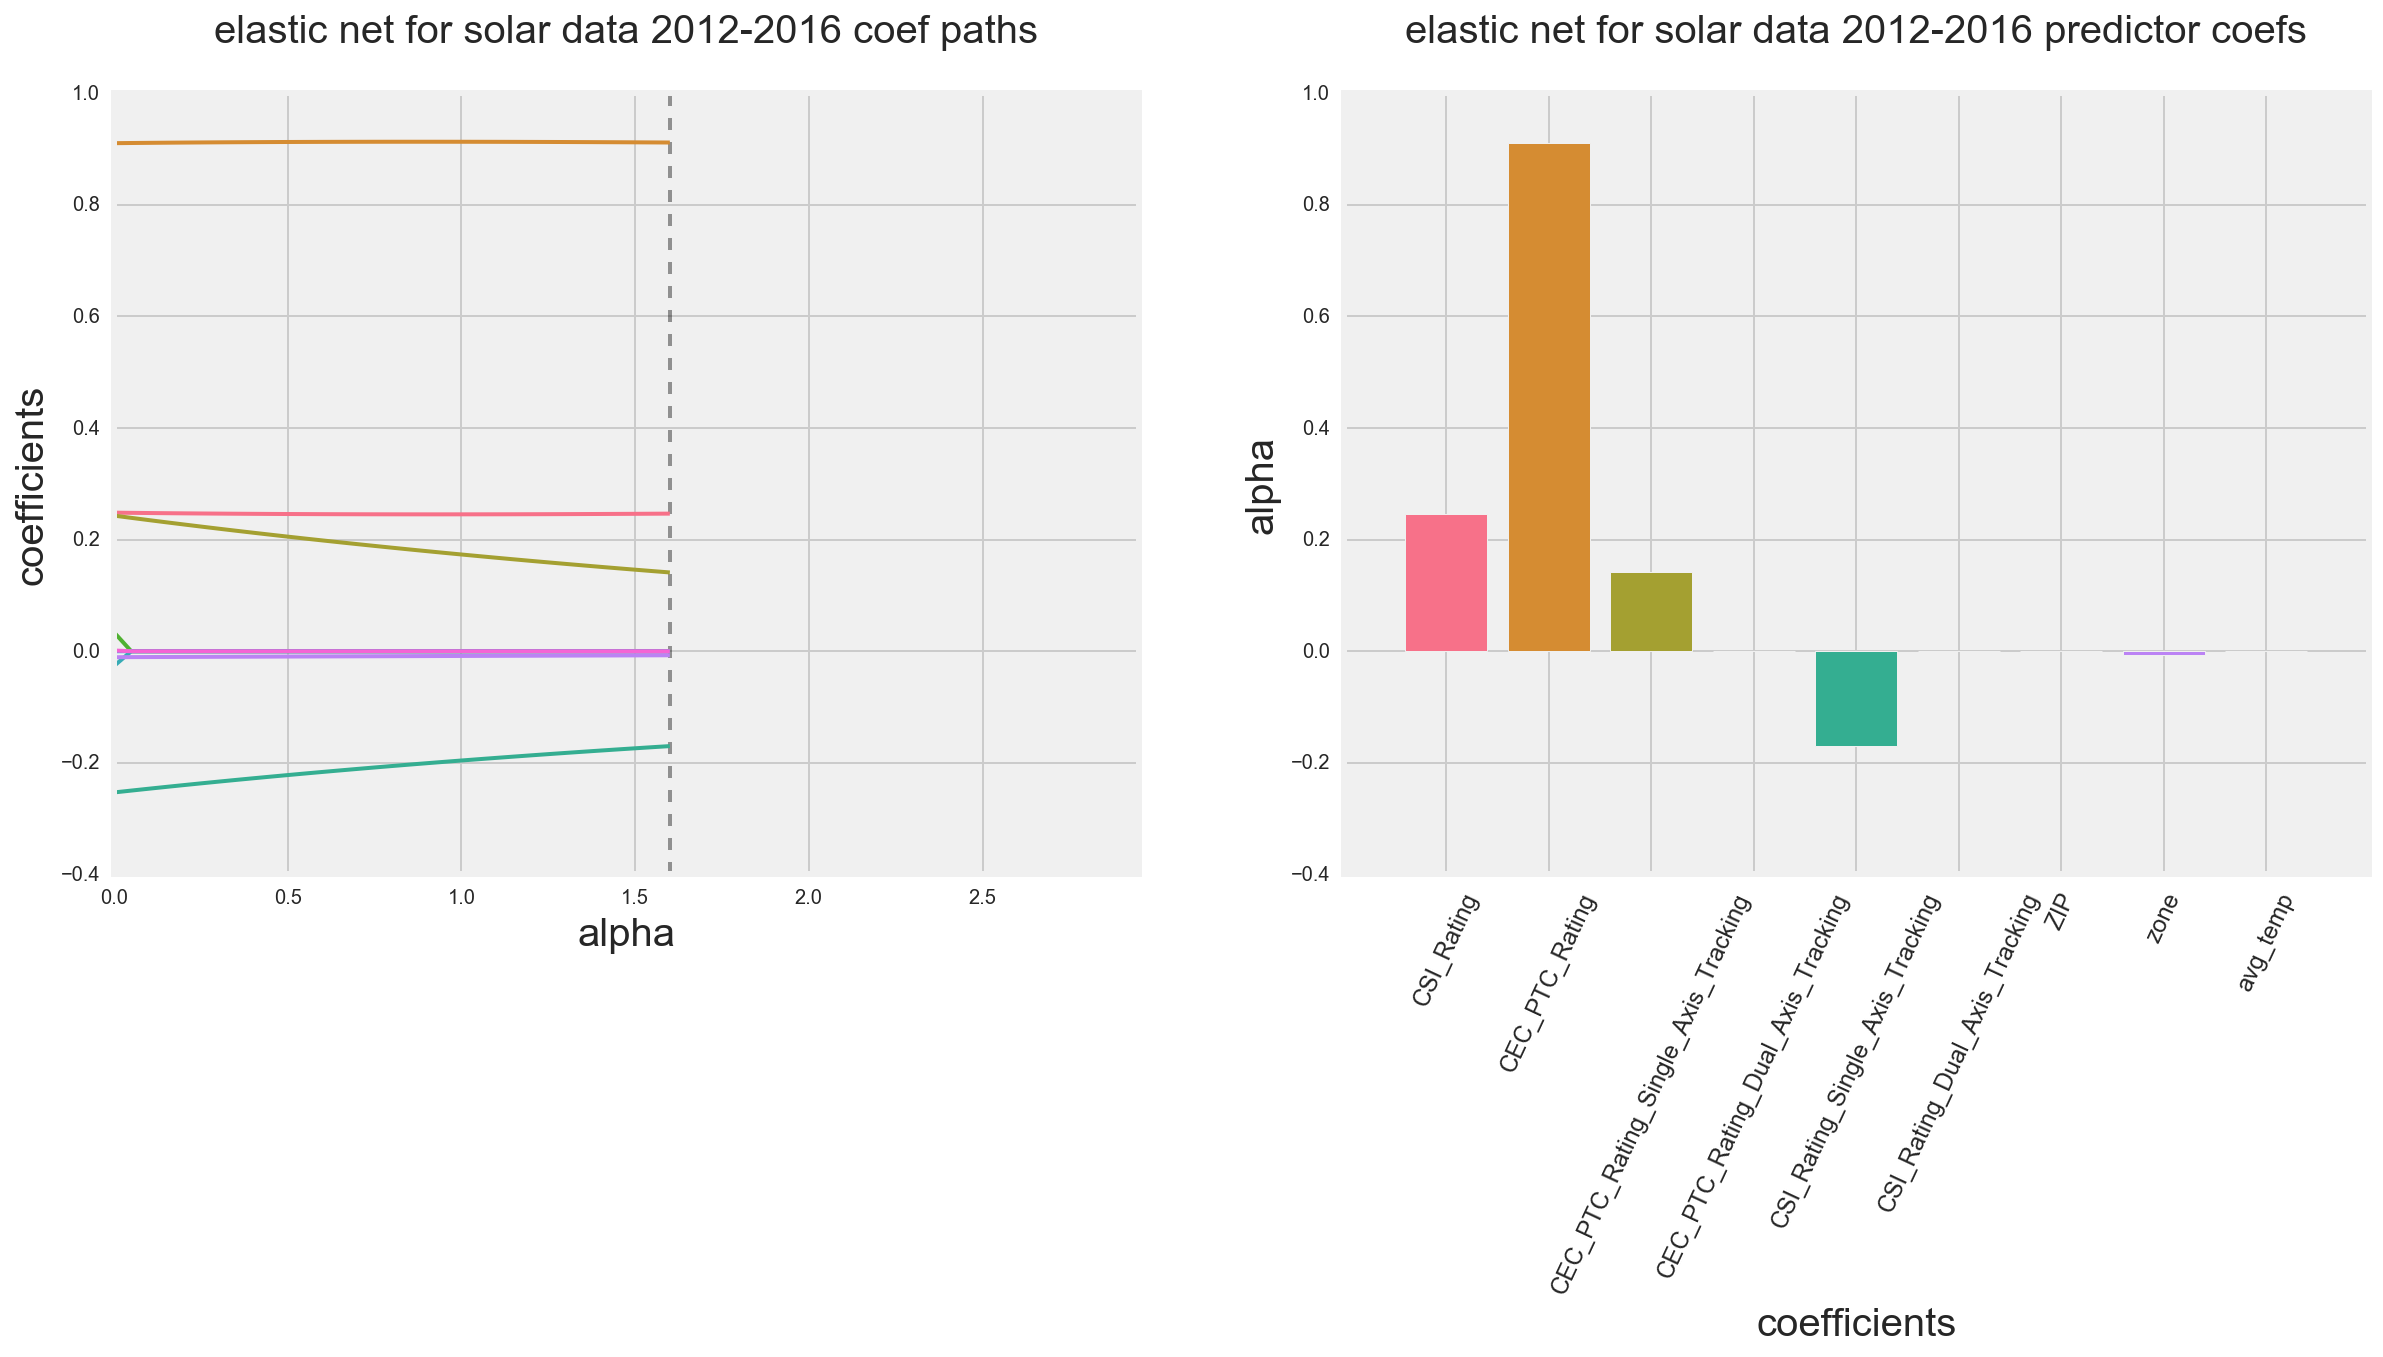

<function __main__.enet_plot_runner>

In [371]:
def enet_plot_runner(alpha=01.60):
    coef_plotter(enet_alphas1, enet_coefs1, simple_feature_names1, alpha, 
                 regtype='elastic net for solar data 2012-2016')

interact(enet_plot_runner, alpha=(0.0,3.0,0.05))

![](4.3.2.1.png)

For CSI_Rating, we have correlation w Nameplate_Rating, CEC_PTC_Rating, CEC_PTC_Rating_Dual axis,, CSI Rating*, zone,
and anti-correlation w CEC_PTC rating single axis. 

<h2> 4.4 Let's also try time series analysis here, since the data also covers 2012-2016. </h2>

In [372]:
ca_nameplate_diff = ca_solar_df_num.Nameplate_Rating.diff()

In [373]:
ca_nameplate_diff.dropna(inplace=True)

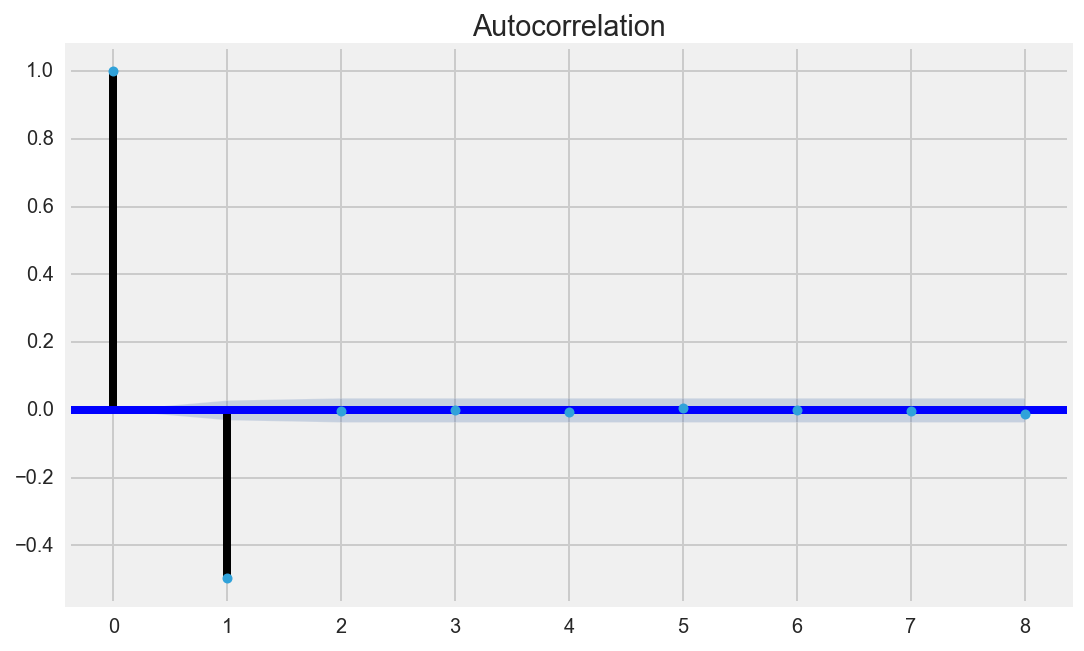

In [374]:
fig = plt.figure(figsize=(8,5))
ax = fig.gca()
plot_acf(ca_nameplate_diff, lags=8, ax=ax)
plt.show()

In [375]:
ar3 = ARMA(ca_nameplate_diff.values, (1,0)).fit()
ar3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 4517
Model:                     ARMA(1, 0)   Log Likelihood              -27570.788
Method:                       css-mle   S.D. of innovations            108.290
Date:                Mon, 10 Oct 2016   AIC                          55147.577
Time:                        10:56:13   BIC                          55166.823
Sample:                             0   HQIC                         55154.357
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.0297      1.076      0.028      0.978        -2.079     2.139
ar.L1.y       -0.4976      0.013    -38.513      0.000        -0.523    -0.472
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.0095           +0.0000j            2.0095            0.5000
-----------------------------------------------------------------------------
"""

In [376]:
r2_score(ca_nameplate_diff, ar3.fittedvalues)

0.24721646884436821

On AWS I get: 0.22957776323642776

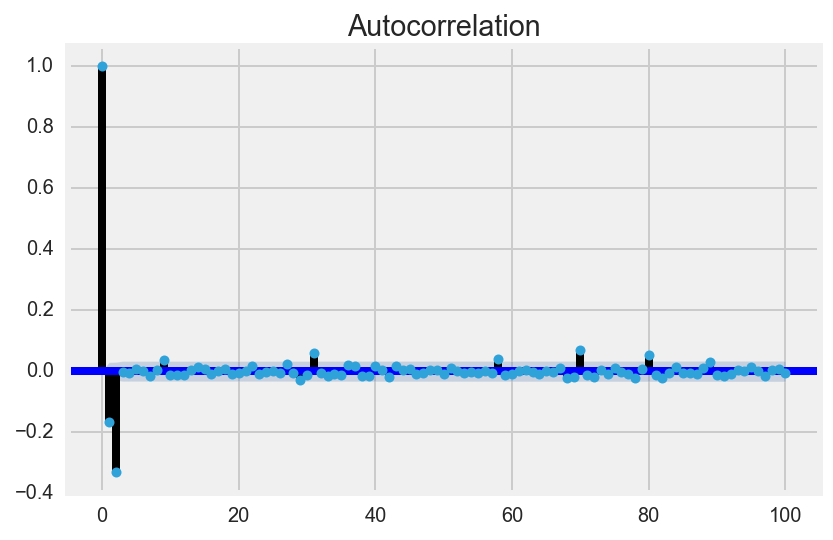

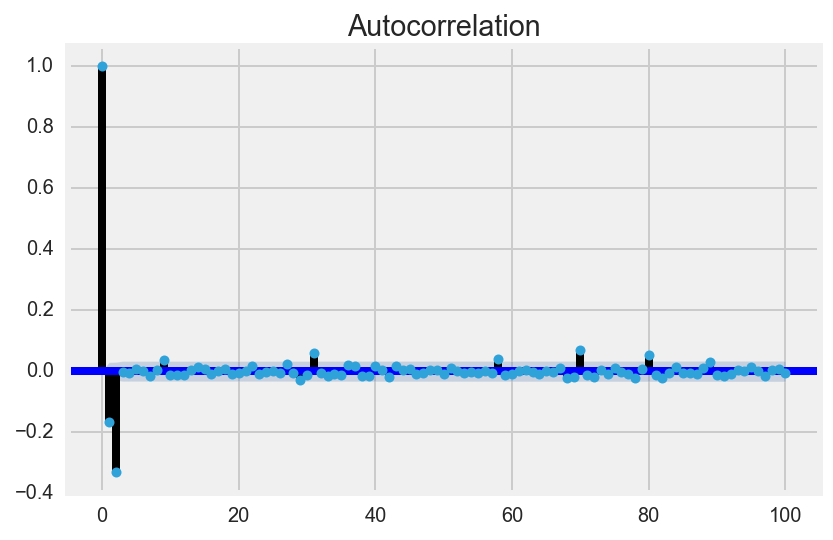

In [377]:
plot_acf(ar3.resid, lags=100)

Likewise, the auto-correlation plot seems OK, so we can trust the time series analysis. 

<h2> 5. Let's merge now the PGE data w the solar data, see what we can learn from that. </h2>

In [378]:
pge_q_num.head(3)

,ZipCode,Month,Year,CustomerClass,Combined,TotalCustomers,TotalkWh,AveragekWh,zone,avg_temp,nameplate,cec,csi,cec_1_track,cec_2_track,csi_1_track,csi_2_track
6404,95252,3,2012,2,1,4367.0,3279187.0,751.0,12.0,57.166667,-2.40,-2.084,-2.057,-0.0,-0.0,-0.0,-0.0
6582,95215,3,2015,2,1,6439.0,3579054.0,556.0,12.0,57.166667,-16.77,-14.482,-14.141,-0.0,-0.0,-0.0,-0.0
1824,95460,1,2015,2,1,1050.0,740381.0,705.0,1.0,52.166667,-8.16,-6.931,-5.828,-0.0,-0.0,-0.0,-0.0


In [379]:
ca_solar_df_num.head(3)

,Nameplate_Rating,CEC_PTC_Rating,CSI_Rating,CEC_PTC_Rating_Single_Axis_Tracking,CEC_PTC_Rating_Dual_Axis_Tracking,CSI_Rating_Single_Axis_Tracking,CSI_Rating_Dual_Axis_Tracking,ZIP,zone,avg_temp
42006,8.16,7.014,6.795,0.0,0.0,0.0,0.0,95132,4.0,57.500000
118,3.00,2.608,2.376,0.0,0.0,0.0,0.0,95070,4.0,57.500000
25094,10.92,9.491,9.226,0.0,0.0,0.0,0.0,94551,12.0,57.166667


In [380]:
ca_solar_df_num.iloc[2,7]

94551.0

In [381]:
zip_to_nameplate_dict = {}
for zip in range(0,ca_solar_df_num.shape[0]):
    zip_val = ca_solar_df_num.iloc[zip, 7]
    kwh_val = ca_solar_df_num.iloc[zip, 0]
    zip_to_nameplate_dict[zip_val]  = kwh_val

In [382]:
pge_q_num['nameplate']  =  -1.0 * pge_q_num['ZipCode'].map(zip_to_nameplate_dict)

In [383]:
pge_q_num.dropna(inplace=True)

In [384]:
zip_to_cec_dict = {}
for zip in range(0,ca_solar_df_num.shape[0]):
    zip_val = ca_solar_df_num.iloc[zip, 7]
    kwh_val = ca_solar_df_num.iloc[zip, 1]
    zip_to_cec_dict[zip_val]  = kwh_val

In [385]:
pge_q_num['cec']  =  -1.0 * pge_q_num['ZipCode'].map(zip_to_cec_dict)

In [386]:
pge_q_num.dropna(inplace=True)

In [387]:
zip_to_csi_dict = {}
for zip in range(0,ca_solar_df_num.shape[0]):
    zip_val = ca_solar_df_num.iloc[zip, 7]
    kwh_val = ca_solar_df_num.iloc[zip, 2]
    zip_to_csi_dict[zip_val]  = kwh_val

In [388]:
pge_q_num['csi']  =  -1.0 * pge_q_num['ZipCode'].map(zip_to_csi_dict)

In [389]:
pge_q_num.dropna(inplace=True)

In [390]:
zip_to_cec_1_tracking_dict = {}
for zip in range(0,ca_solar_df_num.shape[0]):
    zip_val = ca_solar_df_num.iloc[zip, 7]
    kwh_val = ca_solar_df_num.iloc[zip, 3]
    zip_to_cec_1_tracking_dict[zip_val]  = kwh_val

In [391]:
pge_q_num['cec_1_track']  =  -1.0 * pge_q_num['ZipCode'].map(zip_to_cec_1_tracking_dict)

In [392]:
pge_q_num.dropna(inplace=True)

In [393]:
zip_to_cec_2_tracking_dict = {}
for zip in range(0,ca_solar_df_num.shape[0]):
    zip_val = ca_solar_df_num.iloc[zip, 7]
    kwh_val = ca_solar_df_num.iloc[zip, 4]
    zip_to_cec_2_tracking_dict[zip_val]  = kwh_val

In [394]:
pge_q_num['cec_2_track']  =  -1.0 * pge_q_num['ZipCode'].map(zip_to_cec_2_tracking_dict)

In [395]:
pge_q_num.dropna(inplace=True)

In [396]:
zip_to_csi_1_tracking_dict = {}
for zip in range(0,ca_solar_df_num.shape[0]):
    zip_val = ca_solar_df_num.iloc[zip, 7]
    kwh_val = ca_solar_df_num.iloc[zip, 5]
    zip_to_csi_1_tracking_dict[zip_val]  = kwh_val

In [397]:
pge_q_num['csi_1_track']  =  -1.0 * pge_q_num['ZipCode'].map(zip_to_csi_1_tracking_dict)

In [398]:
pge_q_num.dropna(inplace=True)

In [399]:
zip_to_csi_2_tracking_dict = {}
for zip in range(0,ca_solar_df_num.shape[0]):
    zip_val = ca_solar_df_num.iloc[zip, 7]
    kwh_val = ca_solar_df_num.iloc[zip, 6]
    zip_to_csi_2_tracking_dict[zip_val]  = kwh_val

In [400]:
pge_q_num['csi_2_track']  =  -1.0 * pge_q_num['ZipCode'].map(zip_to_csi_2_tracking_dict)

In [401]:
pge_q_num.dropna(inplace=True)

In [402]:
pge_q_num.head(3)

,ZipCode,Month,Year,CustomerClass,Combined,TotalCustomers,TotalkWh,AveragekWh,zone,avg_temp,nameplate,cec,csi,cec_1_track,cec_2_track,csi_1_track,csi_2_track
6404,95252,3,2012,2,1,4367.0,3279187.0,751.0,12.0,57.166667,-3.675,-3.191,-3.033,-0.0,-0.0,-0.0,-0.0
6582,95215,3,2015,2,1,6439.0,3579054.0,556.0,12.0,57.166667,-6.120,-5.267,-4.773,-0.0,-0.0,-0.0,-0.0
1824,95460,1,2015,2,1,1050.0,740381.0,705.0,1.0,52.166667,-4.140,-3.620,-3.130,-0.0,-0.0,-0.0,-0.0


In [403]:
pge_q_num_corr1 = pge_q_num.corr()

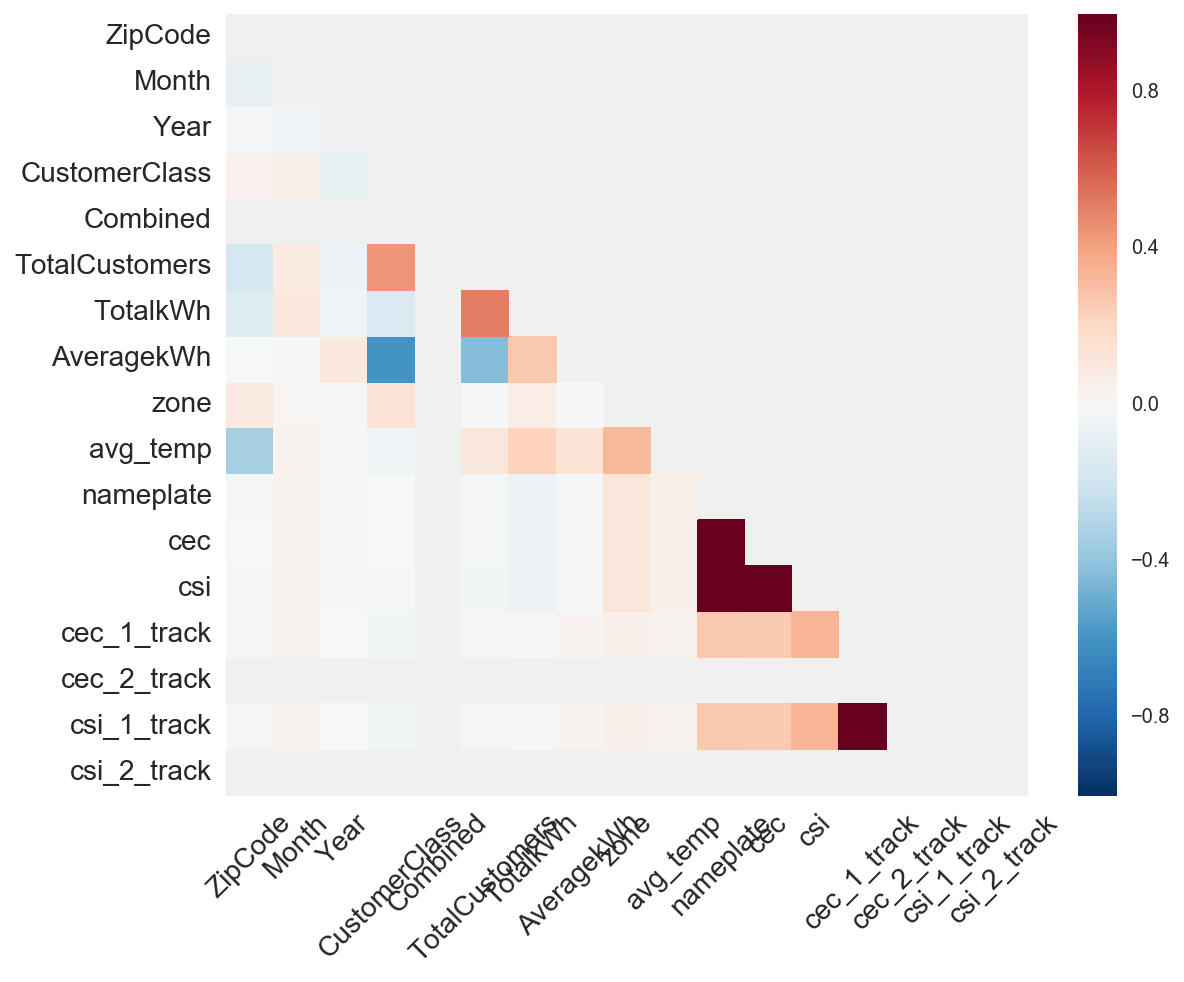

In [404]:
mask = np.zeros_like(pge_q_num_corr1, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(8,7))
ax = sns.heatmap(pge_q_num_corr1, mask=mask)

ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=45)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)

plt.show()

<h2> 5.1  Let's see if there is any correlation between TotalkWh (a PGE datum) 
and nameplate (a solar datum) by zone. </h2>

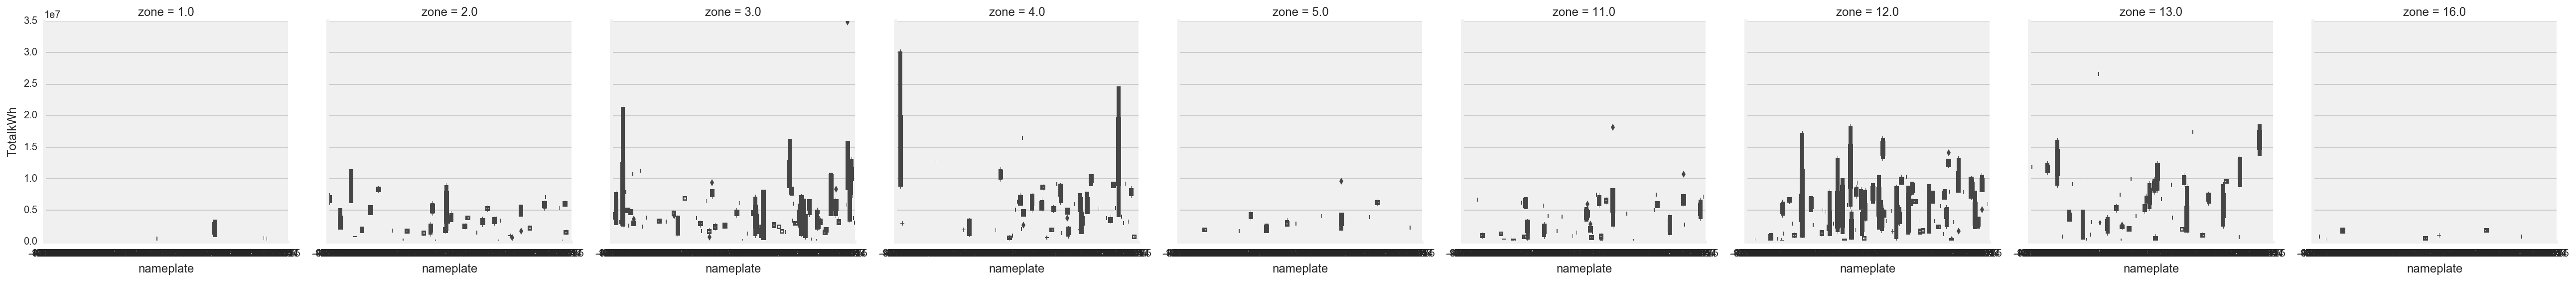

In [405]:
#sns.factorplot(x='Month', y='TotalkWh',col='Year', kind='box', data=pge_q_num)
sns.factorplot(x='nameplate', y='TotalkWh',col='zone', kind='box', data=pge_q_num)

![](5.1.2.1.png)

There is some correlation between Nameplate and TotalkWh in certain zones: 2,3,4, 11,12,13.

<h2> 5.2 Let's do now some Linear Regression. </h2>

In [406]:
formula_simple2 = 'C(TotalkWh) ~  C(nameplate) + C(TotalCustomers) + C(Month) + C(Year) + C(CustomerClass) + \
                   C(cec) + C(csi) + C(cec_2_track) + C(csi_1_track) + C(csi_2_track) -1 '  
# AveragekWh ~ C(TotalCustomers) + Month + Year + C(CustomerClass) + C(zone) + C(avg_temp) -1
#  C(zone) + C(avg_temp) -1 + \ 
print formula_simple2

C(TotalkWh) ~  C(nameplate) + C(TotalCustomers) + C(Month) + C(Year) + C(CustomerClass) +                    C(cec) + C(csi) + C(cec_2_track) + C(csi_1_track) + C(csi_2_track) -1 


In [407]:
Y2, X2 = patsy.dmatrices(formula_simple2, data=pge_q_num)

In [408]:
X2_n = ss.fit_transform(pge_q_num)

In [409]:
linreg2 = LinearRegression()

linreg_scores2 = cross_val_score(linreg2, X2_n, Y2, cv=10)

print linreg_scores2
print np.mean(linreg_scores2)

[-0.01204819 -0.01204819 -0.01204819 -0.01204819 -0.01204819 -0.01204819
 -0.01204819 -0.01204819 -0.01219512 -0.01219512]
-0.0120775786071


<h2> 5.3 I will do now ElasticNet.</h2>

In [410]:
target2 = 'TotalkWh'
non_target_cols2 = ['AveragekWh', 'CustomerClass', 'TotalCustomers', 'ZipCode', 'zone', 'nameplate', 'cec', 'csi' ,
                   'Month','cec_1_track', 'cec_2_track', 'csi_1_track', 'csi_2_track', 'avg_temp']
formula_simple2 = target2 + ' ~ ' + ' + '.join(non_target_cols2) + ' -1'
print formula_simple2

TotalkWh ~ AveragekWh + CustomerClass + TotalCustomers + ZipCode + zone + nameplate + cec + csi + Month + cec_1_track + cec_2_track + csi_1_track + csi_2_track + avg_temp -1


In [411]:
Y2, X2 = patsy.dmatrices(formula_simple2, data=pge_q_num)

In [412]:
simple_feature_names2 = X2.design_info.column_names

In [438]:
enet_alphas2 = np.arange(0, 3.0, 0.05)
enet_score2, enet_coefs2 = elasticnet_coefs(X2, Y2, enet_alphas2)

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:11: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator


In [439]:
print "enet score is: ", enet_score2

enet score is:  0.573239914051


Not great, but not that bad.

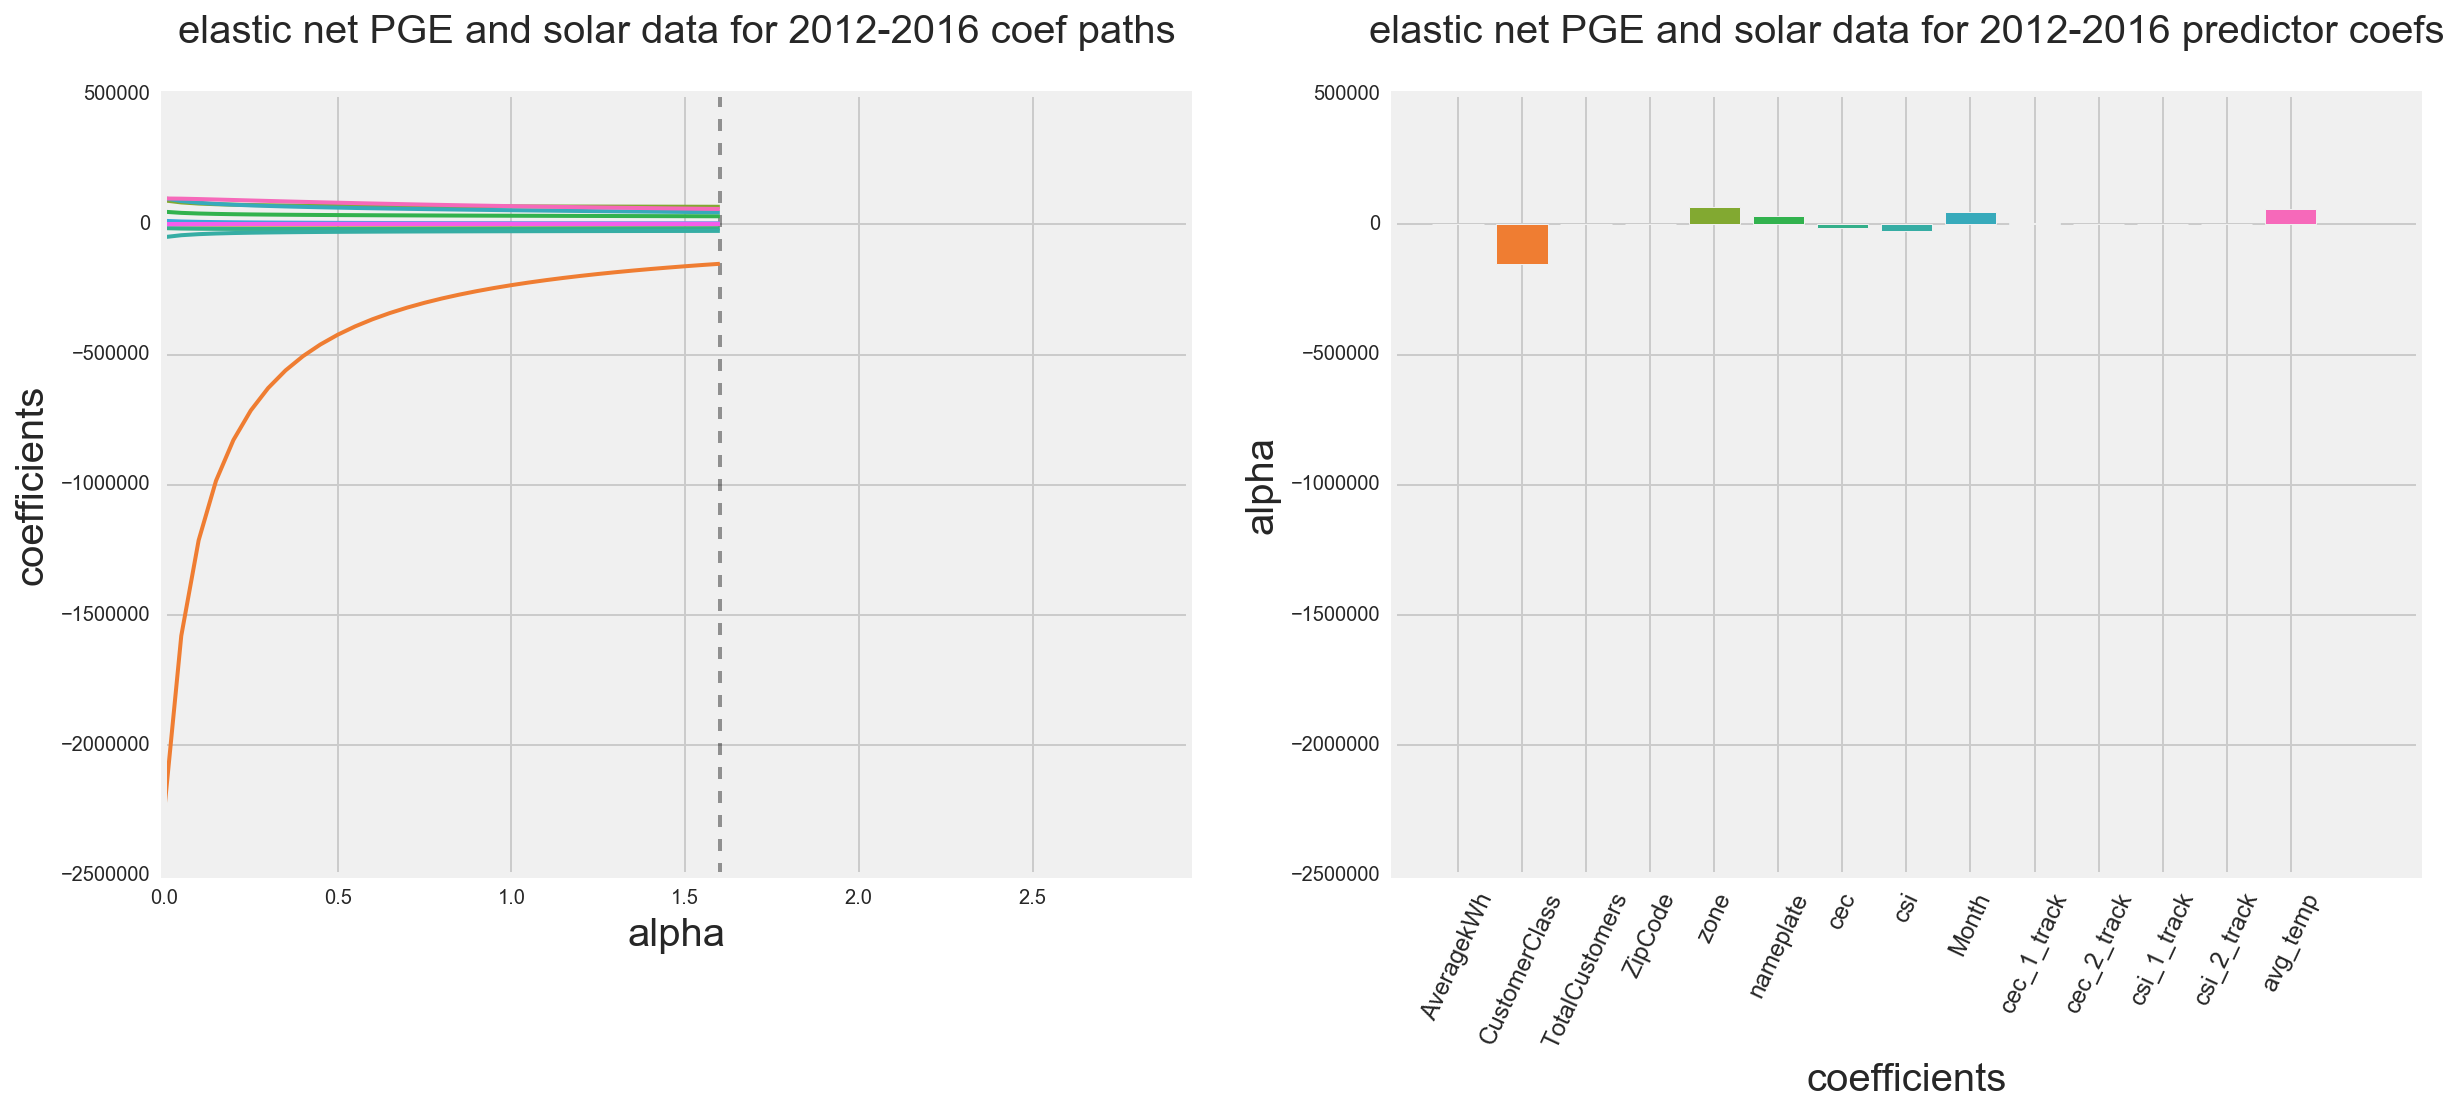

<function __main__.enet_plot_runner>

In [414]:
def enet_plot_runner(alpha=01.6):
    coef_plotter(enet_alphas2, enet_coefs2, simple_feature_names2, alpha, 
                 regtype='elastic net PGE and solar data for 2012-2016')

interact(enet_plot_runner, alpha=(0.0,3.0,0.05))

![](5.4.1.2.png)

In [415]:
pge_q_num.head(3)

,ZipCode,Month,Year,CustomerClass,Combined,TotalCustomers,TotalkWh,AveragekWh,zone,avg_temp,nameplate,cec,csi,cec_1_track,cec_2_track,csi_1_track,csi_2_track
6404,95252,3,2012,2,1,4367.0,3279187.0,751.0,12.0,57.166667,-3.675,-3.191,-3.033,-0.0,-0.0,-0.0,-0.0
6582,95215,3,2015,2,1,6439.0,3579054.0,556.0,12.0,57.166667,-6.120,-5.267,-4.773,-0.0,-0.0,-0.0,-0.0
1824,95460,1,2015,2,1,1050.0,740381.0,705.0,1.0,52.166667,-4.140,-3.620,-3.130,-0.0,-0.0,-0.0,-0.0


<h2> 6. Analysis. </h2>

<h3> 6.1 PGE data analysis </h3>

Regarding the PGE data, it seems that 'TotalkWh' correlates with "zone" and "avg_temp" 
and anti-correlates with "Month", and "CustomerClass". The correlation seems surprising as average temperature 
is concerned, somewhat surprising regarding zones. I would not expect consumption to go up with temperature.
Maybe some of the electricity is used for cooling in hotter zones. Zones 10-16 are more in the desert region of CA. 


Regarding the anti-correlation between TotalkWh and Months, that seems reasonable: as decrease (go from Jun=6 to Jan=1) comsumption increases. There is more consumption in the winter, when is colder. 

There also seems to be some anti-correlation between different CustomerClasses and TotalkWh. The categories are:
Electric-Commercial'=1; 'Electric-Residential'=2; 'Electric-Agricultural'=3;'Electric-Industrial'=4.
Anti-correlation betweek TotalkWh and CustomerClass means that TotalkWh increases as CustomerClass is decreases, so
it is more for Electric-Commercial and Electric-Residential. So it seems these 2 Customer classes consume more electricity. 

On AWS, w the full data set,  TotalkWh correlates w CustomerClass[1], avg_temp, zone, and anti-correlates w CustomerClass[2] and CustomerClass[3].

<h3> 6.2 Solar data analysis </h3>

Regarding solar data, I need more detail data, by month for instance. For CSI_Rating, we have correlation w Nameplate_Rating, CEC_PTC_Rating* , CSI Rating*, zone, and anti-correlation w CEC_PTC rating single axis.
The correlation between Nameplate numbers and CEC* , CSI* numbers make sense, they are kWhs from different types
of panels in similar area. The interesting correlation is between Nameplate Rating and zones. The higher number zones,
like 10-16 are more in the desert part of CA. There, we would expect more sun, hence more electricity from solar panels. 

It is not clear why there is the anti-correlation w CEC_PTC_rating single axis. 

<h3> 6.3 Join PG&E and solar data analysis. </h3>

When our target is 'AveragekWh, and it correlates w 'CustomerClass, and correlates w 'zone', 'nameplate',
and 'avg_temp'. The correlation between AveragekWh and Nameplate, avg_temp(average temperature) makes sense: 
as Nameplate numbers, avg_temp increase, so do AveragekWh. 

The correlation beween AveragekWh and zones is interesting: as zones increase, the location is desert-like. There we expect more sunshine, hence more kWh used (perhaps cooling?!) 

The correlation between AveragekWh and CustomerClass is also intereting: as  in the PG&E data analysis, the higher CustomerClass numbers correspond to Electric-Agricultural and Electric-Industrial. These seem the bigger consumers of
electricity. 

If we switch to 'TotalkWh', we get correlation w 'CustomerClass[3]',  'csi', 'avg_temp', 
'zone' and 'cec'. 

On AWS, w the full data set,  TotalkWh correlates w CustomerClass[1], csi, avg_temp, zone, and anti-correlates w CustomerClass[2] and CustomerClass[3]. 

The correlation between TotalkWh and CSI*, avg_temp and CEC* is interesting: the more TotalkWh used, more solar power is generated by solar panels. So maybe people we switching to more solar power generation. 

The correlation between TotalkWh and avg_temp and zone is reasonable: higher temperature, higher use of electricity (maybe cooling, as above); and higher zones are in the desert, correlating with higher temperature. 

The last correlation, between TotalkWh and CustomerClass[3], Electric-Agricultural is interesting. Perhaps agricultural users need more electricity than other customers. 

<h2> Conclusion. </h2>

A data science project is a bit like making a documentary: we gather data, explore it, analyse it. At the end, 
we hope to find an interesting story to tell. Hopefully this was an interesting story. 